In [5]:
import pdb
import numpy as np
import itertools

#np.random.seed(0)
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.datasets import mnist
from keras import backend as K
from keras.initializers import VarianceScaling
from matplotlib import pyplot as plt

# 6.036 Problem Set 8

## Problem 3

In [6]:
def plot_heat(X, y, model, res = 200):
    eps = .1
    xmin = np.min(X[:,0]) - eps; xmax = np.max(X[:,0]) + eps
    ymin = np.min(X[:,1]) - eps; ymax = np.max(X[:,1]) + eps
    ax = tidyPlot(xmin, xmax, ymin, ymax, xlabel = 'x', ylabel = 'y')
    xl = np.linspace(xmin, xmax, res)
    yl = np.linspace(ymin, ymax, res)
    xx, yy = np.meshgrid(xl, yl, sparse=False)
    zz = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    im = ax.imshow(np.flipud(zz.reshape((res,res))), interpolation = 'none',
                   extent = [xmin, xmax, ymin, ymax],
                   cmap = 'viridis')
    plt.colorbar(im)
    for yi in set([int(_y) for _y in set(y)]):
        color = ['r', 'g', 'b'][yi]
        marker = ['X', 'o', 'v'][yi]
        cl = np.where(y==yi)
        ax.scatter(X[cl,0], X[cl,1], c = color, marker = marker, s=80,
                   edgecolors = 'none')
    return ax

In [7]:
def tidyPlot(xmin, xmax, ymin, ymax, center = False, title = None,
                 xlabel = None, ylabel = None):
    plt.figure(facecolor="white")
    ax = plt.subplot()
    if center:
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_smart_bounds(True)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    else:
        ax.spines["top"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left()
    eps = .05
    plt.xlim(xmin-eps, xmax+eps)
    plt.ylim(ymin-eps, ymax+eps)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    return ax

In [8]:
def get_data_set(name):
    try:
        data = np.loadtxt(name, skiprows=0, delimiter = ' ')
    except:
        return None, None, None
    np.random.shuffle(data)             # shuffle the data
    # The data uses ROW vectors for a data point, that's what Keras assumes.
    _, d = data.shape
    X = data[:,0:d-1]
    Y = data[:,d-1:d]
    y = Y.T[0]
    classes = set(y)
    if classes == set([-1.0, 1.0]):
        print('Convert from -1,1 to 0,1')
        y = 0.5*(y+1)
    print('Loading X', X.shape, 'y', y.shape, 'classes', set(y))
    return X, y, len(classes)

In [9]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.keys = ['loss', 'acc', 'val_loss', 'val_acc']
        self.values = {}
        for k in self.keys:
            self.values['batch_'+k] = []
            self.values['epoch_'+k] = []

    def on_batch_end(self, batch, logs={}):
        for k in self.keys:
            bk = 'batch_'+k
            if k in logs:
                self.values[bk].append(logs[k])

    def on_epoch_end(self, epoch, logs={}):
        for k in self.keys:
            ek = 'epoch_'+k
            if k in logs:
                self.values[ek].append(logs[k])

    def plot(self, keys):
        for key in keys:
            plt.plot(np.arange(len(self.values[key])), np.array(self.values[key]), label=key)
        plt.legend()

In [10]:
def run_keras(X_train, y_train, X_val, y_val, X_test, y_test, layers, epochs, split=0, verbose=True):
    # Model specification
    model = Sequential()
    for layer in layers:
        model.add(layer)
    # Define the optimization
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])
    N = X_train.shape[0]
    # Pick batch size
    batch = 32 if N > 1000 else 1     # batch size
    history = LossHistory()
    # Fit the model
    if X_val is None:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=split,
                  callbacks=[history], verbose=verbose)
    else:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_val, y_val),
                  callbacks=[history], verbose=verbose)
    # Evaluate the model on validation data, if any
    if X_val is not None or split > 0:
        val_acc, val_loss = history.values['epoch_val_acc'][-1], history.values['epoch_val_loss'][-1]
        print ("\nLoss on validation set:"  + str(val_loss) + " Accuracy on validation set: " + str(val_acc))
    else:
        val_acc = None
    # Evaluate the model on test data, if any
    if X_test is not None:
        test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch)
        print ("\nLoss on test set:"  + str(test_loss) + " Accuracy on test set: " + str(test_acc))
    else:
        test_acc = None
    return model, history, val_acc, test_acc

In [11]:
def dataset_paths(data_name):
    return ["data/data"+data_name+"_"+suffix+".csv" for suffix in ("train", "validate", "test")]

In [12]:
def run_keras_2d(data_name, layers, epochs, display=True, split=0.25, verbose=True, trials=1):
    print('Keras FC: dataset=', data_name)
    (train_dataset, val_dataset, test_dataset) = dataset_paths(data_name)
    # Load the datasets
    X_train, y, num_classes = get_data_set(train_dataset)
    X_val, y2, _ = get_data_set(val_dataset)
    X_test, y3, _ = get_data_set(test_dataset)
    # Categorize the labels
    y_train = np_utils.to_categorical(y, num_classes) # one-hot
    y_val = y_test = None
    if X_val is not None:
        y_val = np_utils.to_categorical(y2, num_classes) # one-hot        
    if X_test is not None:
        y_test = np_utils.to_categorical(y3, num_classes) # one-hot
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc, = \
               run_keras(X_train, y_train, X_val, y_val, X_test, y_test, layers, epochs,
                         split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y, model)
            plt.title('Training data')
            plt.show()
            if X_test is not None:
                # plot classifier landscape on testing data
                plot_heat(X_test, y3, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            history.plot(['epoch_loss', 'epoch_val_loss'])
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.show()
            # Plot epoch accuracy
            history.plot(['epoch_acc', 'epoch_val_acc'])
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))
    return X_train, y, model

In [13]:
def archs(classes):
    return [[Dense(input_dim=2, units=classes, activation="softmax")],
            [Dense(input_dim=2, units=10, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=10, activation='relu'),
             Dense(units=10, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=100, activation='relu'),
             Dense(units=classes, activation="softmax")]]

### Part 1

Dataset: 1 Architecture: 1

Keras FC: dataset= 1
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1033 - acc: 0.9825 - val_loss: 0.0572 - val_acc: 1.0000
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0522 - acc: 0.9975 - val_loss: 0.0329 - val_acc: 1.0000
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0356 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.0170 - val_acc: 1.0000
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0220 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 1.0000
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.00

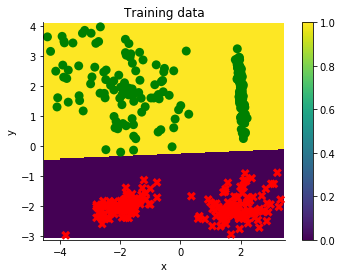

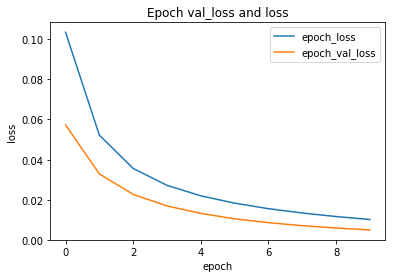

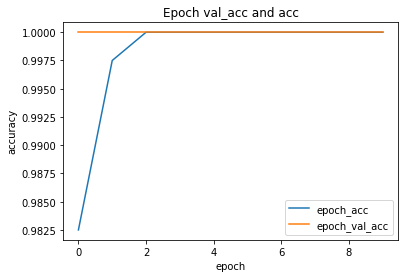

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3005 - acc: 0.8550 - val_loss: 0.1613 - val_acc: 0.9650
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.1342 - acc: 0.9650 - val_loss: 0.0870 - val_acc: 0.9950
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0827 - acc: 0.9875 - val_loss: 0.0573 - val_acc: 0.9950
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0598 - acc: 0.9925 - val_loss: 0.0417 - val_acc: 1.0000
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0468 - acc: 0.9925 - val_loss: 0.0324 - val_acc: 1.0000
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0383 - acc: 0.9925 - val_loss: 0.0259 - val_acc: 1.0000
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0320 - acc: 0.9925 - val_loss: 0.0211 - val_acc: 1.0000
Epoch 8/10
400/400 [==========

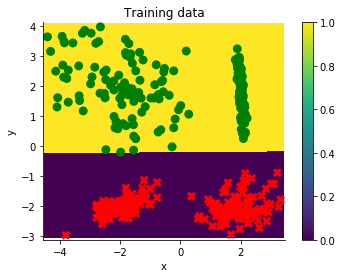

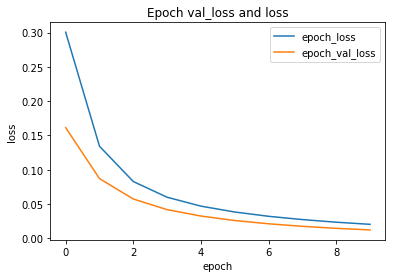

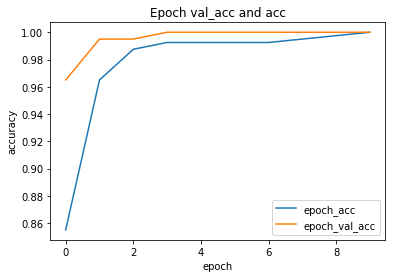

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 1.1115 - acc: 0.4975 - val_loss: 0.7391 - val_acc: 0.4600
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4612 - acc: 0.7000 - val_loss: 0.2980 - val_acc: 0.9550
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 0.2204 - acc: 0.9700 - val_loss: 0.1591 - val_acc: 1.0000
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.1369 - acc: 0.9925 - val_loss: 0.1050 - val_acc: 1.0000
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0980 - acc: 1.0000 - val_loss: 0.0763 - val_acc: 1.0000
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0758 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 1.0000
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0611 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 1.0000
Epoch 8/10
400/400 [==========

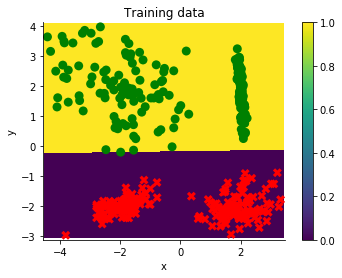

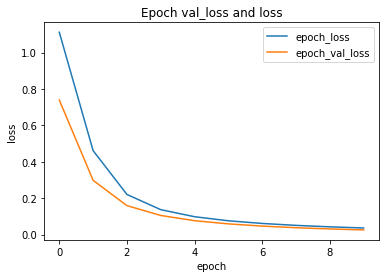

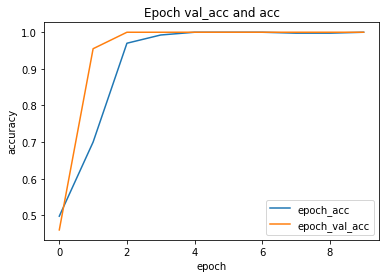

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 1.4747 - acc: 0.3925 - val_loss: 0.9433 - val_acc: 0.5450
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.6909 - acc: 0.5725 - val_loss: 0.4305 - val_acc: 0.8250
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3367 - acc: 0.9575 - val_loss: 0.2379 - val_acc: 0.9950
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2037 - acc: 0.9875 - val_loss: 0.1553 - val_acc: 0.9950
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.1420 - acc: 0.9900 - val_loss: 0.1114 - val_acc: 1.0000
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.1066 - acc: 0.9925 - val_loss: 0.0838 - val_acc: 1.0000
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.0837 - acc: 0.9925 - val_loss: 0.0653 - val_acc: 1.0000
Epoch 8/10
400/400 [==========

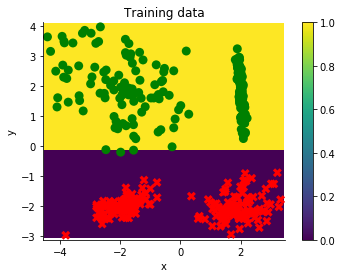

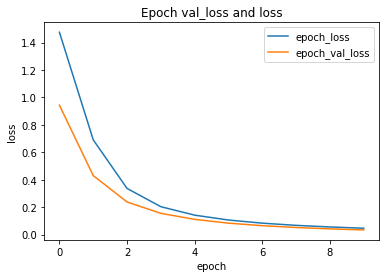

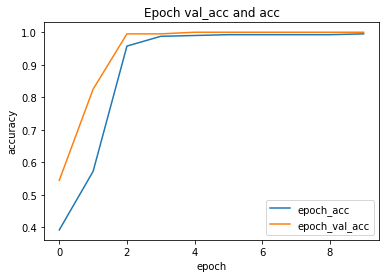

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 2.0069 - acc: 0.4900 - val_loss: 1.6116 - val_acc: 0.4500
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 1.0480 - acc: 0.5025 - val_loss: 0.7000 - val_acc: 0.4800
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4510 - acc: 0.7200 - val_loss: 0.2947 - val_acc: 0.9350
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2202 - acc: 0.9550 - val_loss: 0.1598 - val_acc: 0.9900
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.1361 - acc: 0.9850 - val_loss: 0.1046 - val_acc: 1.0000
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0975 - acc: 0.9975 - val_loss: 0.0764 - val_acc: 1.0000
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.0759 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 1.0000
Epoch 8/10
400/400 [==========

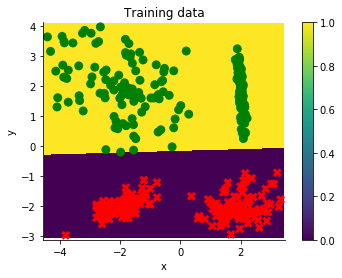

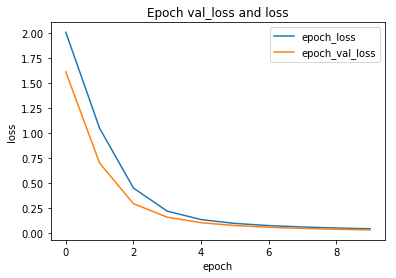

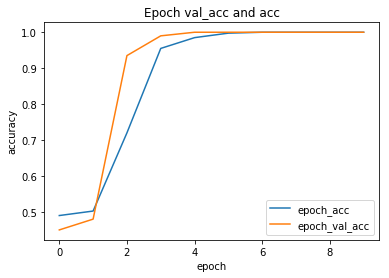


Avg. validation accuracy:1.0


(array([[ 1.48421152, -2.41993738],
        [ 2.31918074, -1.80887825],
        [ 2.05245256,  1.01486053],
        [-4.08762468,  1.61947291],
        [-2.1164326 , -2.04773708],
        [ 1.99175387,  1.86393082],
        [ 2.05095008,  1.77226265],
        [ 1.90592407,  2.70558522],
        [-2.14358858,  0.83114145],
        [-0.70940383,  1.58257734],
        [ 2.10616712,  0.90081811],
        [-3.58119822,  3.44380351],
        [-0.78141344, -1.20239749],
        [ 1.26174009, -2.00918166],
        [ 1.99873105,  2.09459354],
        [ 2.09918573, -1.14502146],
        [ 2.09619958,  0.25949462],
        [-1.77601903, -1.85677944],
        [-2.81837163,  3.43182409],
        [-2.32694986,  2.03512347],
        [ 1.95519219, -1.99100085],
        [-1.7619772 , -1.96077818],
        [-1.89414917, -2.11614913],
        [-1.00418842, -1.41106295],
        [-3.94137401,  3.66444264],
        [ 2.13886208,  0.77223557],
        [-0.55547702,  2.47860247],
        [-2.20096442, -2.257

In [18]:
run_keras_2d("1", archs(2)[0], 10, trials=5)

Average Validation Accuracy: 100.0%

Dataset: 2 Architecture: 1

Keras FC: dataset= 2
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 1.0645 - acc: 0.4625 - val_loss: 0.8883 - val_acc: 0.5400
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.7648 - acc: 0.5800 - val_loss: 0.6348 - val_acc: 0.6300
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.5879 - acc: 0.6975 - val_loss: 0.5058 - val_acc: 0.8300
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4982 - acc: 0.8050 - val_loss: 0.4480 - val_acc: 0.8450
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4542 - acc: 0.8250 - val_loss: 0.4210 - val_acc: 0.8400
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4311 - acc: 0.8250 - val_loss: 0.4071 - val_acc: 0.83

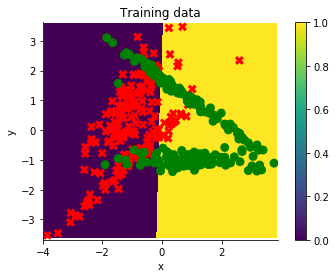

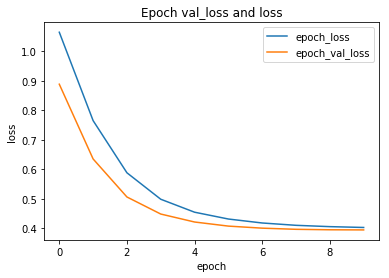

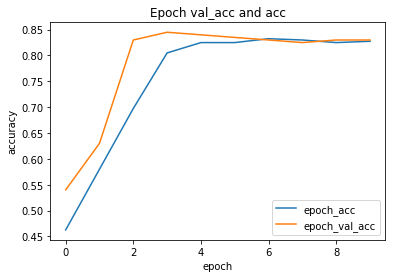

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 0.6775 - acc: 0.5475 - val_loss: 0.5832 - val_acc: 0.7650
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.5302 - acc: 0.8125 - val_loss: 0.4872 - val_acc: 0.8300
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4653 - acc: 0.8275 - val_loss: 0.4432 - val_acc: 0.8150
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4349 - acc: 0.8225 - val_loss: 0.4210 - val_acc: 0.8200
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4190 - acc: 0.8200 - val_loss: 0.4099 - val_acc: 0.8150
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4105 - acc: 0.8200 - val_loss: 0.4035 - val_acc: 0.8100
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4061 - acc: 0.8225 - val_loss: 0.3998 - val_acc: 0.8150
Epoch 8/10
400/400 [==========

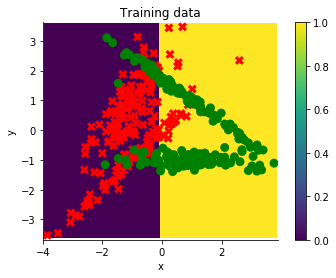

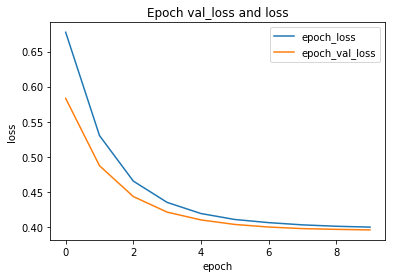

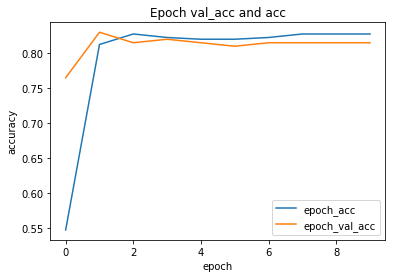

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 5ms/step - loss: 0.8598 - acc: 0.5125 - val_loss: 0.7596 - val_acc: 0.5450
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.6287 - acc: 0.6450 - val_loss: 0.5870 - val_acc: 0.6700
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.5093 - acc: 0.7475 - val_loss: 0.4976 - val_acc: 0.7350
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4519 - acc: 0.7925 - val_loss: 0.4530 - val_acc: 0.7950
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4254 - acc: 0.8150 - val_loss: 0.4290 - val_acc: 0.8150
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4129 - acc: 0.8200 - val_loss: 0.4168 - val_acc: 0.8300
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4070 - acc: 0.8300 - val_loss: 0.4103 - val_acc: 0.8300
Epoch 8/10
400/400 [==========

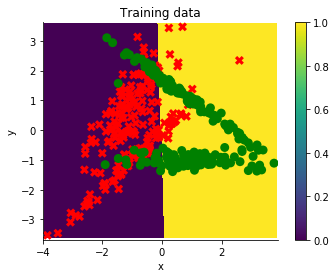

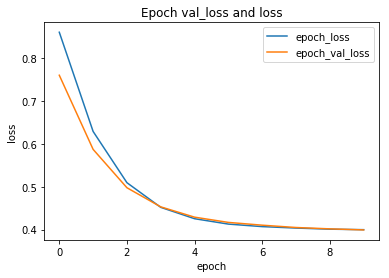

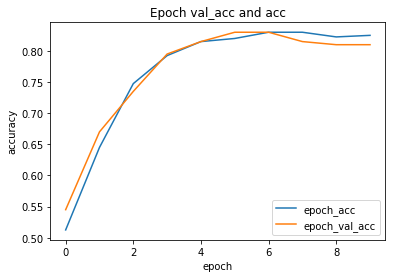

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 5ms/step - loss: 2.0564 - acc: 0.2000 - val_loss: 1.8106 - val_acc: 0.1750
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 1.5374 - acc: 0.2275 - val_loss: 1.3315 - val_acc: 0.2600
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 1.1174 - acc: 0.3400 - val_loss: 0.9583 - val_acc: 0.3650
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.8127 - acc: 0.4325 - val_loss: 0.7140 - val_acc: 0.4850
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.6276 - acc: 0.6475 - val_loss: 0.5742 - val_acc: 0.7150
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.5287 - acc: 0.7925 - val_loss: 0.4990 - val_acc: 0.8000
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4763 - acc: 0.8100 - val_loss: 0.4589 - val_acc: 0.8300
Epoch 8/10
400/400 [==========

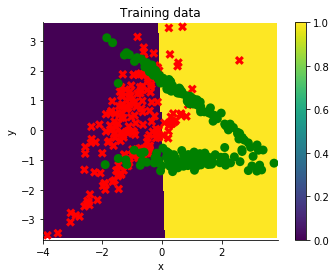

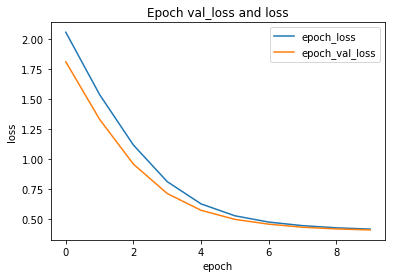

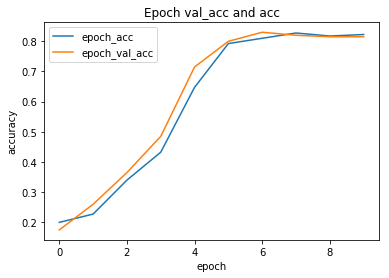

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 6ms/step - loss: 1.3453 - acc: 0.1850 - val_loss: 1.1465 - val_acc: 0.1500
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.9590 - acc: 0.1875 - val_loss: 0.8144 - val_acc: 0.2150
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.7073 - acc: 0.4875 - val_loss: 0.6244 - val_acc: 0.7500
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.5692 - acc: 0.8175 - val_loss: 0.5237 - val_acc: 0.8150
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4974 - acc: 0.8275 - val_loss: 0.4694 - val_acc: 0.8250
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4582 - acc: 0.8200 - val_loss: 0.4382 - val_acc: 0.8200
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4353 - acc: 0.8200 - val_loss: 0.4223 - val_acc: 0.8200
Epoch 8/10
400/400 [==========

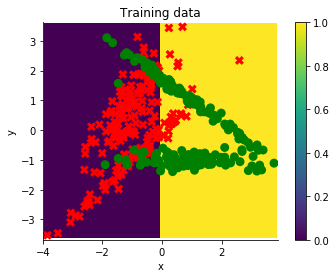

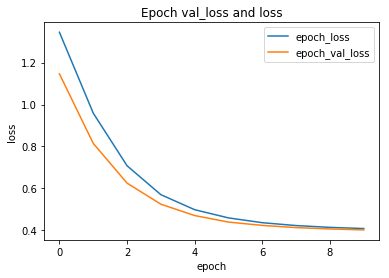

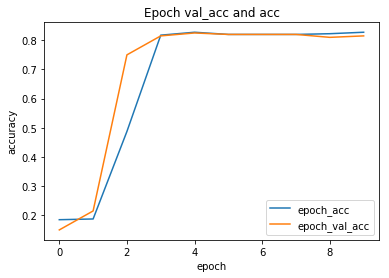


Avg. validation accuracy:0.817


(array([[-1.35954469e+00,  4.12253503e-01],
        [-7.14648423e-01, -7.21520901e-01],
        [ 1.05994811e+00,  1.03747218e+00],
        [ 3.08360544e-01, -1.16684146e+00],
        [-1.26191468e+00,  2.51863932e+00],
        [-1.15121409e+00, -3.41179981e-02],
        [-6.56994421e-01,  9.79162187e-01],
        [ 1.68331248e+00, -1.08368613e+00],
        [ 1.28582961e+00, -1.09647456e+00],
        [-1.10228747e+00, -1.09571841e+00],
        [-4.19772033e-01, -1.61455877e-01],
        [ 9.11255946e-01, -9.59918736e-01],
        [-2.60168743e+00, -2.56066661e+00],
        [ 1.27035750e+00, -7.89908472e-01],
        [-9.82064734e-01, -2.67181538e-02],
        [ 1.27621763e+00, -1.04805327e+00],
        [ 7.25919966e-01, -8.40558190e-01],
        [-2.00387447e+00, -7.74858858e-01],
        [ 6.45990947e-01,  4.89172146e-01],
        [ 3.02060944e+00, -1.20300597e+00],
        [-1.48103028e+00, -1.55116116e+00],
        [ 2.53951333e+00, -7.29674348e-02],
        [-1.08957216e-01,  2.426

In [19]:
run_keras_2d("2", archs(2)[0], 10, trials=5)

Average Validation Accuracy: 81.7%

Dataset: 2 Architecture: 2

Keras FC: dataset= 2
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 6ms/step - loss: 0.5349 - acc: 0.6475 - val_loss: 0.4403 - val_acc: 0.8500
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4156 - acc: 0.8175 - val_loss: 0.3706 - val_acc: 0.8450
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3654 - acc: 0.8275 - val_loss: 0.3432 - val_acc: 0.8500
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3446 - acc: 0.8425 - val_loss: 0.3307 - val_acc: 0.8500
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3334 - acc: 0.8500 - val_loss: 0.3256 - val_acc: 0.8500
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3279 - acc: 0.8500 - val_loss: 0.3213 - val_acc: 0.87

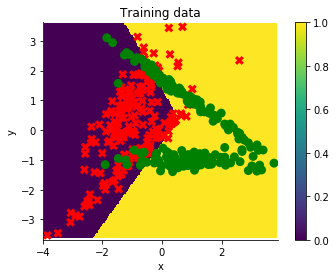

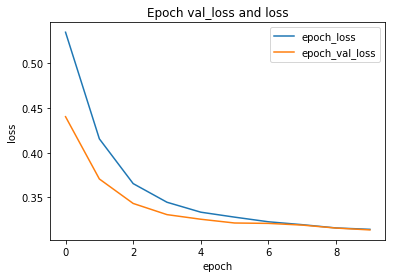

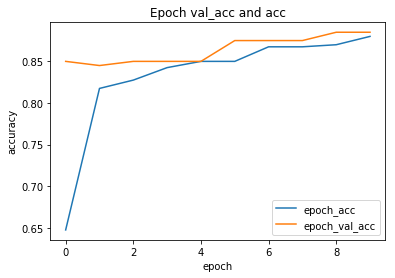

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 6ms/step - loss: 0.5533 - acc: 0.7375 - val_loss: 0.4620 - val_acc: 0.8600
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4268 - acc: 0.8425 - val_loss: 0.3898 - val_acc: 0.8500
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3756 - acc: 0.8475 - val_loss: 0.3582 - val_acc: 0.8650
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3569 - acc: 0.8500 - val_loss: 0.3446 - val_acc: 0.8650
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3460 - acc: 0.8550 - val_loss: 0.3380 - val_acc: 0.8600
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3393 - acc: 0.8550 - val_loss: 0.3357 - val_acc: 0.8650
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3339 - acc: 0.8575 - val_loss: 0.3300 - val_acc: 0.8750
Epoch 8/10
400/400 [==========

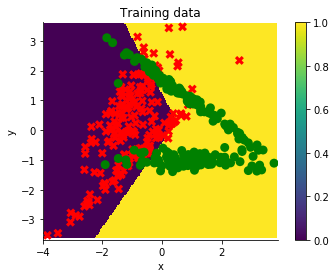

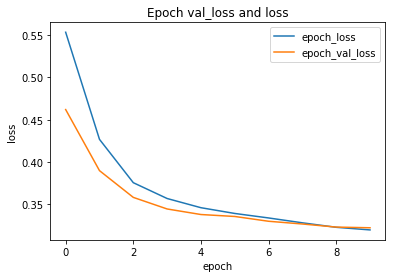

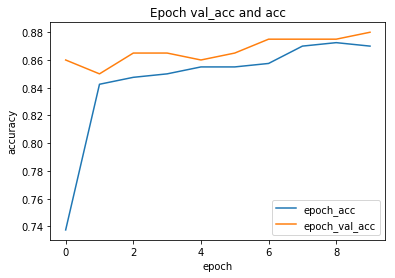

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 6ms/step - loss: 0.5286 - acc: 0.7550 - val_loss: 0.4106 - val_acc: 0.8300
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.3914 - acc: 0.8275 - val_loss: 0.3643 - val_acc: 0.8350
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3651 - acc: 0.8350 - val_loss: 0.3473 - val_acc: 0.8400
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3542 - acc: 0.8400 - val_loss: 0.3380 - val_acc: 0.8450
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3475 - acc: 0.8375 - val_loss: 0.3337 - val_acc: 0.8450
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3408 - acc: 0.8500 - val_loss: 0.3286 - val_acc: 0.8450
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3347 - acc: 0.8425 - val_loss: 0.3233 - val_acc: 0.8700
Epoch 8/10
400/400 [==========

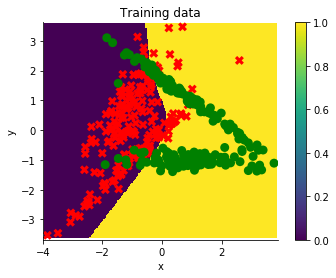

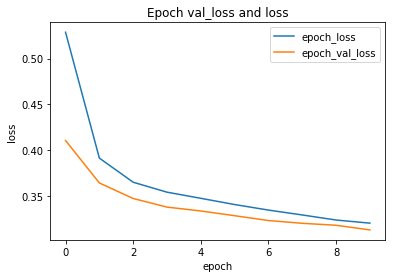

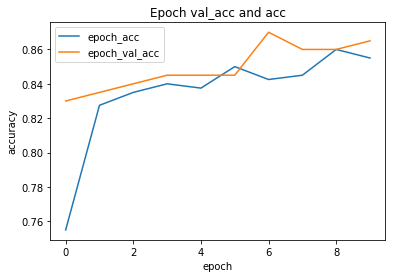

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 7ms/step - loss: 0.8426 - acc: 0.5300 - val_loss: 0.5864 - val_acc: 0.6300
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.5027 - acc: 0.7950 - val_loss: 0.4448 - val_acc: 0.8350
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4304 - acc: 0.8225 - val_loss: 0.4109 - val_acc: 0.8350
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4060 - acc: 0.8350 - val_loss: 0.3915 - val_acc: 0.8400
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3938 - acc: 0.8350 - val_loss: 0.3818 - val_acc: 0.8400
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3819 - acc: 0.8325 - val_loss: 0.3730 - val_acc: 0.8300
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3728 - acc: 0.8325 - val_loss: 0.3671 - val_acc: 0.8400
Epoch 8/10
400/400 [==========

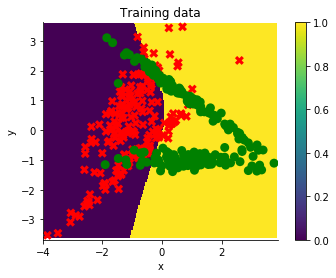

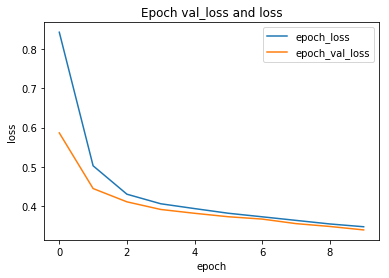

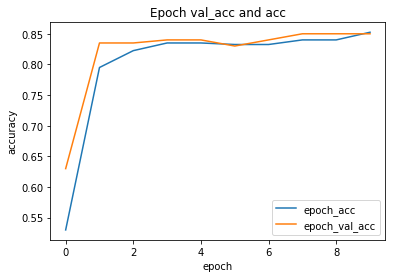

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 6ms/step - loss: 0.6884 - acc: 0.5400 - val_loss: 0.5463 - val_acc: 0.7400
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4726 - acc: 0.8000 - val_loss: 0.4494 - val_acc: 0.7850
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4119 - acc: 0.8350 - val_loss: 0.4070 - val_acc: 0.8250
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3877 - acc: 0.8350 - val_loss: 0.3838 - val_acc: 0.8300
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3738 - acc: 0.8425 - val_loss: 0.3692 - val_acc: 0.8500
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3637 - acc: 0.8400 - val_loss: 0.3590 - val_acc: 0.8450
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3554 - acc: 0.8375 - val_loss: 0.3512 - val_acc: 0.8450
Epoch 8/10
400/400 [==========

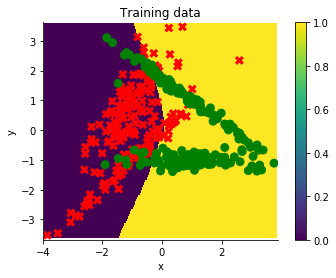

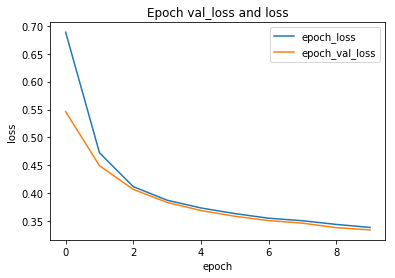

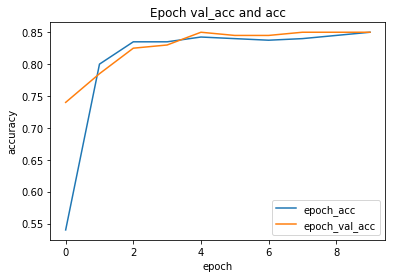


Avg. validation accuracy:0.866


(array([[-7.29678795e-01,  1.23888643e+00],
        [-7.93556771e-01, -7.88516236e-01],
        [ 1.06082281e+00, -1.11885549e+00],
        [ 5.18914019e-01,  1.24502639e+00],
        [ 1.27621763e+00, -1.04805327e+00],
        [-1.95841437e-01, -2.67822051e-01],
        [-4.06029615e-01, -5.24708973e-01],
        [-1.66640200e+00,  9.67777299e-01],
        [ 8.19755298e-01,  4.60879228e-01],
        [ 1.09082642e+00, -1.34696817e+00],
        [-1.13580376e+00, -1.20385579e+00],
        [-6.71602824e-01, -7.68705151e-01],
        [-1.18649873e+00, -1.18973055e+00],
        [-5.10640051e-01, -1.07910459e+00],
        [ 1.94384782e-01, -9.86623532e-01],
        [-1.28607425e+00, -1.35485789e+00],
        [ 8.74059390e-01, -1.19176435e+00],
        [-9.41722312e-01, -6.40421937e-02],
        [-2.57254344e+00, -5.67245715e-01],
        [-1.21230484e+00, -1.00046553e+00],
        [-6.56994421e-01,  9.79162187e-01],
        [-4.19772033e-01, -1.61455877e-01],
        [ 2.28863998e+00,  2.031

In [20]:
run_keras_2d("2", archs(2)[1], 10, trials=5)

Average Validation Accuracy: 86.6%

Dataset: 2 Architecture: 3

Keras FC: dataset= 2
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4460 - acc: 0.8075 - val_loss: 0.3558 - val_acc: 0.8400
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3524 - acc: 0.8450 - val_loss: 0.3332 - val_acc: 0.8550
Epoch 3/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3338 - acc: 0.8425 - val_loss: 0.3407 - val_acc: 0.8600
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3227 - acc: 0.8650 - val_loss: 0.3077 - val_acc: 0.8800
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3152 - acc: 0.8800 - val_loss: 0.3020 - val_acc: 0.8700
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3051 - acc: 0.8725 - val_loss: 0.2899 - val_acc: 0.88

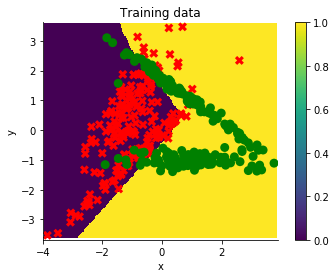

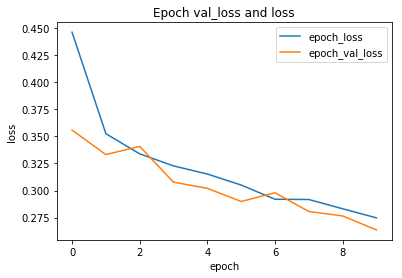

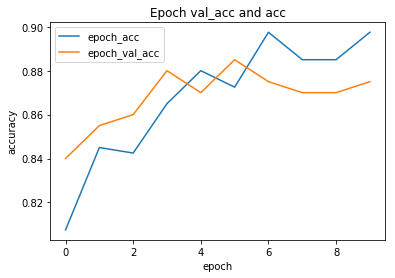

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 6ms/step - loss: 0.4029 - acc: 0.8325 - val_loss: 0.3524 - val_acc: 0.8400
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3471 - acc: 0.8525 - val_loss: 0.3215 - val_acc: 0.8700
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3279 - acc: 0.8550 - val_loss: 0.3134 - val_acc: 0.8750
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3199 - acc: 0.8675 - val_loss: 0.3126 - val_acc: 0.8700
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3080 - acc: 0.8875 - val_loss: 0.3185 - val_acc: 0.8750
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3062 - acc: 0.8850 - val_loss: 0.2907 - val_acc: 0.8800
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2958 - acc: 0.8950 - val_loss: 0.2855 - val_acc: 0.8900
Epoch 8/10
400/400 [==========

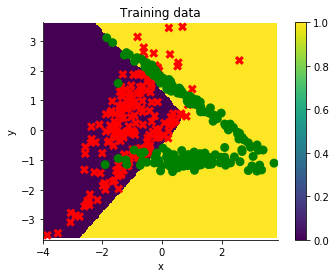

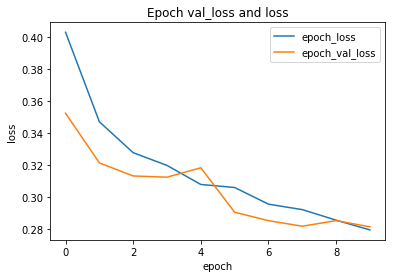

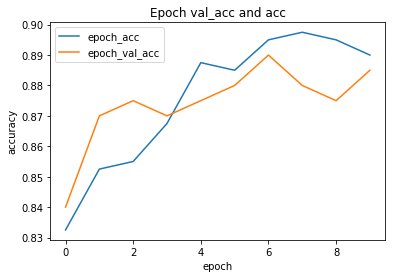

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 6ms/step - loss: 0.4324 - acc: 0.8100 - val_loss: 0.3555 - val_acc: 0.8450
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3482 - acc: 0.8525 - val_loss: 0.3326 - val_acc: 0.8500
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3328 - acc: 0.8550 - val_loss: 0.3152 - val_acc: 0.8700
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3208 - acc: 0.8700 - val_loss: 0.3047 - val_acc: 0.8850
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3132 - acc: 0.8850 - val_loss: 0.3021 - val_acc: 0.8850
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3065 - acc: 0.8925 - val_loss: 0.2929 - val_acc: 0.8900
Epoch 7/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3002 - acc: 0.8850 - val_loss: 0.2893 - val_acc: 0.8850
Epoch 8/10
400/400 [==========

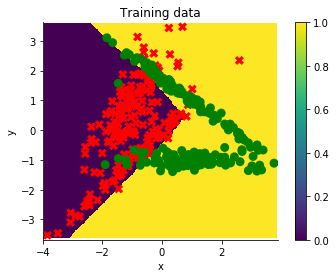

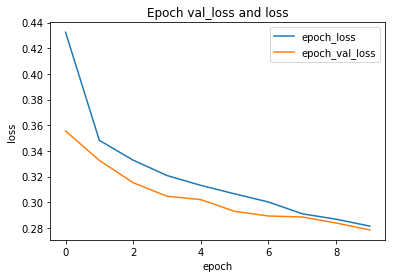

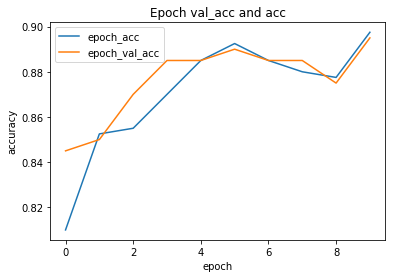

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 6ms/step - loss: 0.4358 - acc: 0.8225 - val_loss: 0.3587 - val_acc: 0.8500
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3608 - acc: 0.8450 - val_loss: 0.3306 - val_acc: 0.8550
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3417 - acc: 0.8600 - val_loss: 0.3274 - val_acc: 0.8550
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3268 - acc: 0.8775 - val_loss: 0.3106 - val_acc: 0.8850
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3187 - acc: 0.8600 - val_loss: 0.3056 - val_acc: 0.8850
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3144 - acc: 0.8650 - val_loss: 0.3002 - val_acc: 0.8800
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3005 - acc: 0.8800 - val_loss: 0.2911 - val_acc: 0.8800
Epoch 8/10
400/400 [==========

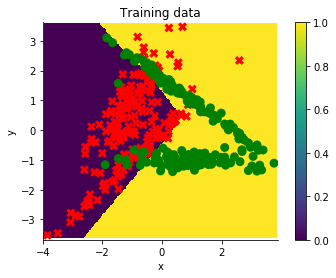

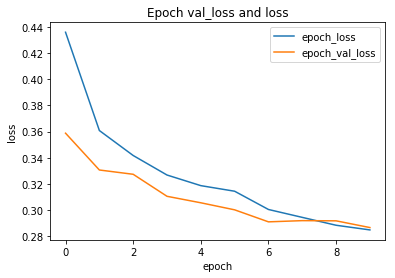

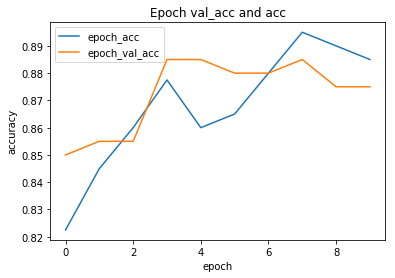

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4211 - acc: 0.8425 - val_loss: 0.3539 - val_acc: 0.8500
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3496 - acc: 0.8550 - val_loss: 0.3289 - val_acc: 0.8550
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3347 - acc: 0.8650 - val_loss: 0.3179 - val_acc: 0.8600
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3259 - acc: 0.8625 - val_loss: 0.3128 - val_acc: 0.8700
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3165 - acc: 0.8725 - val_loss: 0.3139 - val_acc: 0.8700
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3080 - acc: 0.8900 - val_loss: 0.2998 - val_acc: 0.8700
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3007 - acc: 0.8850 - val_loss: 0.2957 - val_acc: 0.8850
Epoch 8/10
400/400 [==========

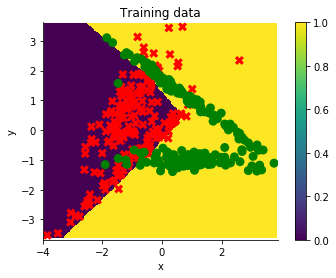

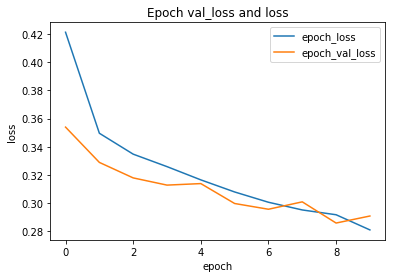

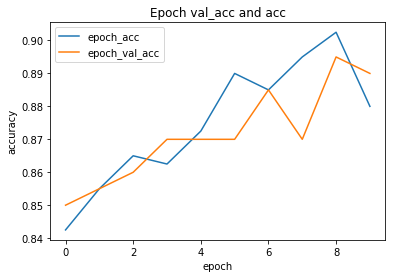


Avg. validation accuracy:0.884


(array([[ 1.29690447e+00,  6.12584986e-01],
        [-7.29678795e-01,  1.23888643e+00],
        [-1.10228747e+00, -1.09571841e+00],
        [ 5.97812083e-01, -1.15361297e+00],
        [-5.03929692e-01,  2.19314649e+00],
        [ 1.60663203e+00, -1.13067848e+00],
        [-1.24883647e-01, -1.41134448e-01],
        [ 2.61954387e+00, -1.05985923e+00],
        [-6.89366568e-01,  7.23940587e-01],
        [-9.00968364e-01,  9.42808569e-01],
        [-2.57583372e+00, -7.90985772e-01],
        [-2.38213776e+00, -4.27446912e-01],
        [-4.69034360e-01, -7.51710454e-01],
        [-2.88914171e+00, -2.85959001e+00],
        [ 1.05994811e+00,  1.03747218e+00],
        [-1.81229220e+00, -4.08248228e-01],
        [-1.48103028e+00, -1.55116116e+00],
        [-1.41195475e+00,  1.28715574e+00],
        [-6.56994421e-01,  9.79162187e-01],
        [ 2.92020832e-01,  1.43316007e+00],
        [ 3.27843287e+00, -1.17543098e+00],
        [-1.56702723e+00, -2.57259783e-01],
        [ 1.57779603e+00,  5.939

In [21]:
run_keras_2d("2", archs(2)[2], 10, trials=5)

Average Validation Accuracy: 88.4%

Dataset: 2 Architecture: 4

Keras FC: dataset= 2
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 8ms/step - loss: 0.6329 - acc: 0.6550 - val_loss: 0.4680 - val_acc: 0.8500
Epoch 2/10
400/400 [==============================] - 1s 4ms/step - loss: 0.4059 - acc: 0.8450 - val_loss: 0.3471 - val_acc: 0.8700
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3495 - acc: 0.8475 - val_loss: 0.3225 - val_acc: 0.8600
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3307 - acc: 0.8600 - val_loss: 0.3159 - val_acc: 0.8500
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3217 - acc: 0.8500 - val_loss: 0.3032 - val_acc: 0.8700
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3098 - acc: 0.8700 - val_loss: 0.2989 - val_acc: 0.88

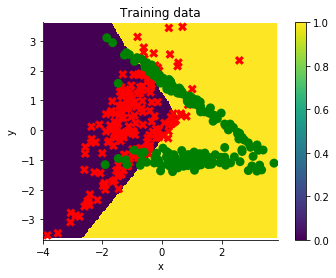

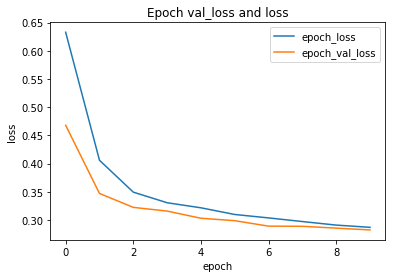

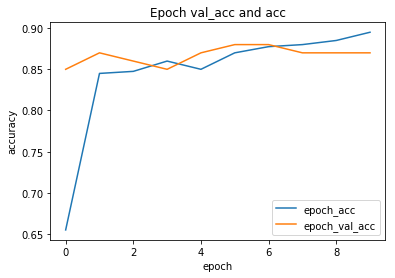

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 8ms/step - loss: 0.4810 - acc: 0.7975 - val_loss: 0.3936 - val_acc: 0.8150
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3798 - acc: 0.8375 - val_loss: 0.3643 - val_acc: 0.8350
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3608 - acc: 0.8325 - val_loss: 0.3505 - val_acc: 0.8400
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3500 - acc: 0.8525 - val_loss: 0.3383 - val_acc: 0.8550
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3396 - acc: 0.8575 - val_loss: 0.3257 - val_acc: 0.8450
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3331 - acc: 0.8600 - val_loss: 0.3154 - val_acc: 0.8550
Epoch 7/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3221 - acc: 0.8625 - val_loss: 0.3112 - val_acc: 0.8650
Epoch 8/10
400/400 [==========

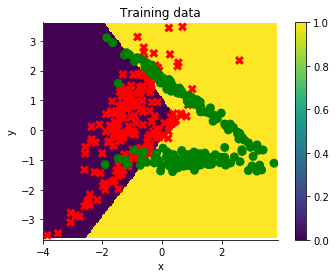

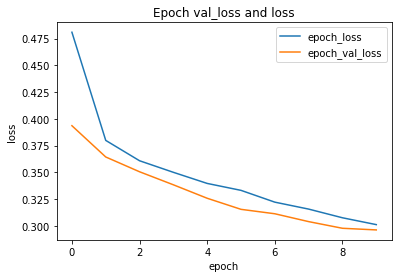

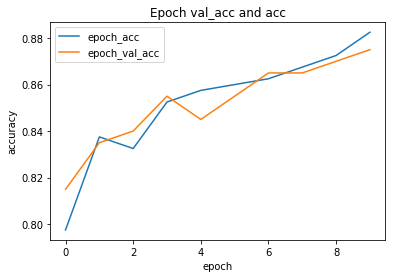

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 8ms/step - loss: 0.5901 - acc: 0.7250 - val_loss: 0.5089 - val_acc: 0.8200
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4541 - acc: 0.8350 - val_loss: 0.3936 - val_acc: 0.8400
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3704 - acc: 0.8475 - val_loss: 0.3421 - val_acc: 0.8500
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3411 - acc: 0.8650 - val_loss: 0.3219 - val_acc: 0.8650
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3242 - acc: 0.8600 - val_loss: 0.3059 - val_acc: 0.8800
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3082 - acc: 0.8750 - val_loss: 0.2958 - val_acc: 0.8850
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2952 - acc: 0.8875 - val_loss: 0.2818 - val_acc: 0.8750
Epoch 8/10
400/400 [==========

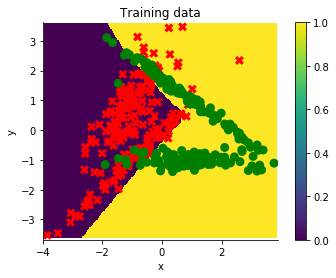

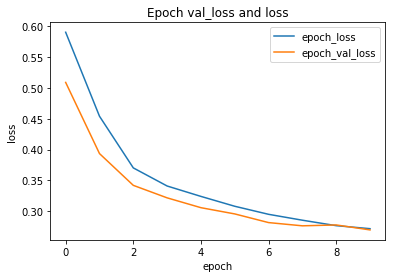

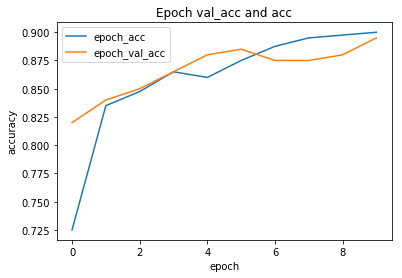

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 9ms/step - loss: 0.5720 - acc: 0.7600 - val_loss: 0.4447 - val_acc: 0.8400
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3905 - acc: 0.8475 - val_loss: 0.3399 - val_acc: 0.8650
Epoch 3/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3447 - acc: 0.8550 - val_loss: 0.3205 - val_acc: 0.8700
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3299 - acc: 0.8600 - val_loss: 0.3092 - val_acc: 0.8700
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3157 - acc: 0.8675 - val_loss: 0.3033 - val_acc: 0.8700
Epoch 6/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3072 - acc: 0.8775 - val_loss: 0.2968 - val_acc: 0.8700
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2982 - acc: 0.8850 - val_loss: 0.2931 - val_acc: 0.8850
Epoch 8/10
400/400 [==========

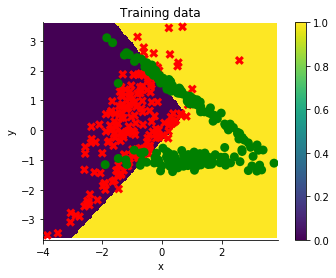

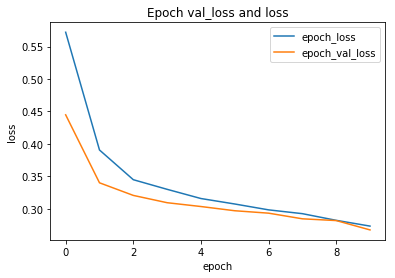

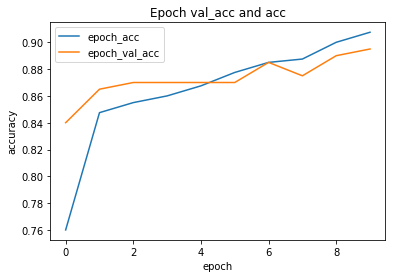

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 3s 9ms/step - loss: 0.5273 - acc: 0.7700 - val_loss: 0.4004 - val_acc: 0.8350
Epoch 2/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3812 - acc: 0.8300 - val_loss: 0.3538 - val_acc: 0.8450
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3566 - acc: 0.8525 - val_loss: 0.3413 - val_acc: 0.8450
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3448 - acc: 0.8550 - val_loss: 0.3301 - val_acc: 0.8500
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3347 - acc: 0.8550 - val_loss: 0.3160 - val_acc: 0.8650
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3255 - acc: 0.8550 - val_loss: 0.3069 - val_acc: 0.8700
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3170 - acc: 0.8600 - val_loss: 0.2994 - val_acc: 0.8750
Epoch 8/10
400/400 [==========

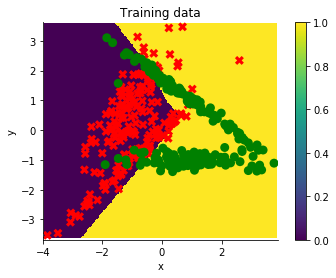

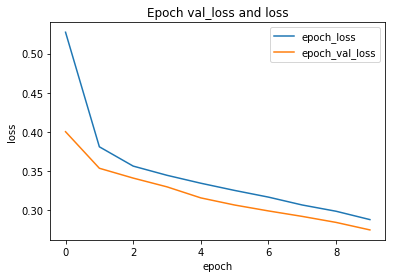

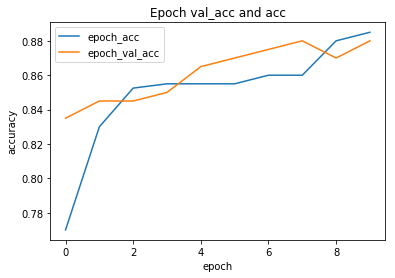


Avg. validation accuracy:0.883


(array([[ 2.53951333e+00, -7.29674348e-02],
        [-1.18512673e+00,  7.00500961e-01],
        [-1.46867783e+00,  2.11090221e-01],
        [-1.74081340e+00,  1.60936263e-01],
        [-2.50101622e+00, -2.37689187e+00],
        [ 1.06082281e+00, -1.11885549e+00],
        [-8.37372488e-01,  2.43210108e+00],
        [ 1.98855244e+00,  5.71003530e-01],
        [-2.09917294e+00,  1.84756054e-01],
        [-2.60372971e+00, -1.33239916e+00],
        [-1.36750918e+00,  1.15409568e+00],
        [-1.93709034e-01,  1.85199160e+00],
        [ 1.03561105e+00,  1.05972780e+00],
        [-1.85258485e+00,  3.09931699e+00],
        [ 2.98135036e-01,  4.43167581e-01],
        [ 1.17777437e+00,  1.01847217e+00],
        [-1.21230484e+00, -1.00046553e+00],
        [-5.10640051e-01, -1.07910459e+00],
        [ 1.01633165e+00,  1.37710735e+00],
        [-3.76479700e-01,  1.45439639e+00],
        [-5.89423801e-01,  2.26165633e+00],
        [-2.16376388e+00, -2.34818460e+00],
        [-1.62337680e+00, -5.244

In [23]:
run_keras_2d("2", archs(2)[3], 10, trials=5)

Average Validation Accuracy: 88.3%

Dataset: 2 Architecture: 5

Keras FC: dataset= 2
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3913 - acc: 0.8350 - val_loss: 0.3256 - val_acc: 0.8650
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3374 - acc: 0.8650 - val_loss: 0.3008 - val_acc: 0.8500
Epoch 3/10
400/400 [==============================] - 3s 6ms/step - loss: 0.3196 - acc: 0.8850 - val_loss: 0.2953 - val_acc: 0.8800
Epoch 4/10
400/400 [==============================] - 2s 6ms/step - loss: 0.3087 - acc: 0.8800 - val_loss: 0.2782 - val_acc: 0.8950
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2847 - acc: 0.8900 - val_loss: 0.3047 - val_acc: 0.8650
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2931 - acc: 0.8725 - val_loss: 0.2984 - val_acc: 0.8

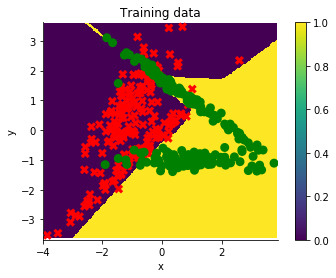

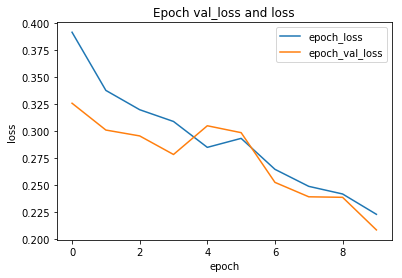

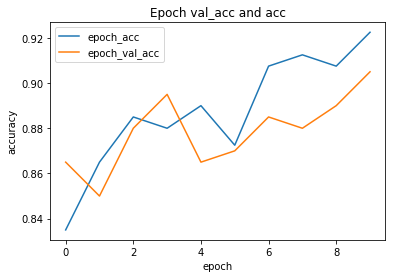

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 8s 21ms/step - loss: 0.3976 - acc: 0.8425 - val_loss: 0.3256 - val_acc: 0.8650
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3427 - acc: 0.8550 - val_loss: 0.3120 - val_acc: 0.8700
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3235 - acc: 0.8750 - val_loss: 0.3134 - val_acc: 0.8600
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3003 - acc: 0.8925 - val_loss: 0.3997 - val_acc: 0.7900
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2966 - acc: 0.8850 - val_loss: 0.2754 - val_acc: 0.8850
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2787 - acc: 0.8975 - val_loss: 0.2650 - val_acc: 0.8800
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2579 - acc: 0.9025 - val_loss: 0.2528 - val_acc: 0.9000
Epoch 8/10
400/400 [=========

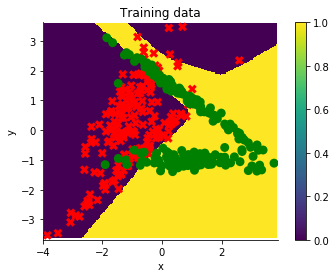

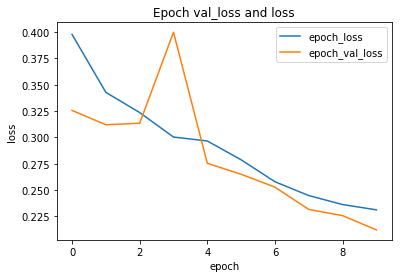

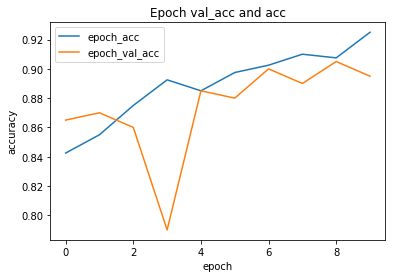

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 9s 22ms/step - loss: 0.3947 - acc: 0.8350 - val_loss: 0.3346 - val_acc: 0.8450
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3369 - acc: 0.8625 - val_loss: 0.3186 - val_acc: 0.8850
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3103 - acc: 0.8650 - val_loss: 0.3019 - val_acc: 0.8850
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3052 - acc: 0.8925 - val_loss: 0.2660 - val_acc: 0.8900
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2764 - acc: 0.8900 - val_loss: 0.2713 - val_acc: 0.8850
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2638 - acc: 0.8975 - val_loss: 0.2524 - val_acc: 0.8900
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2563 - acc: 0.9025 - val_loss: 0.2536 - val_acc: 0.8950
Epoch 8/10
400/400 [=========

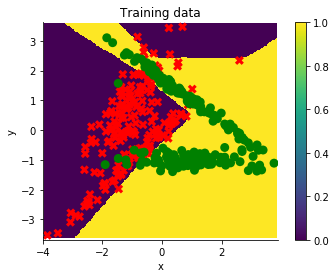

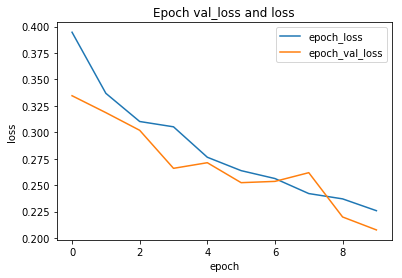

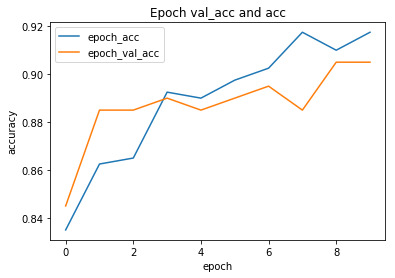

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 8s 20ms/step - loss: 0.3926 - acc: 0.8250 - val_loss: 0.3135 - val_acc: 0.8750
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3306 - acc: 0.8700 - val_loss: 0.2895 - val_acc: 0.8500
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3077 - acc: 0.8675 - val_loss: 0.3476 - val_acc: 0.8550
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3006 - acc: 0.8750 - val_loss: 0.3192 - val_acc: 0.8750
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2926 - acc: 0.8750 - val_loss: 0.2754 - val_acc: 0.8700
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2722 - acc: 0.8975 - val_loss: 0.2870 - val_acc: 0.9000
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2582 - acc: 0.9025 - val_loss: 0.2420 - val_acc: 0.8950
Epoch 8/10
400/400 [=========

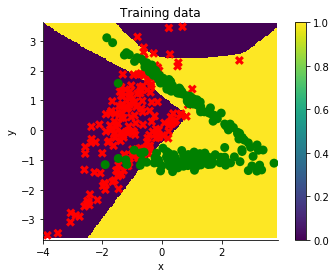

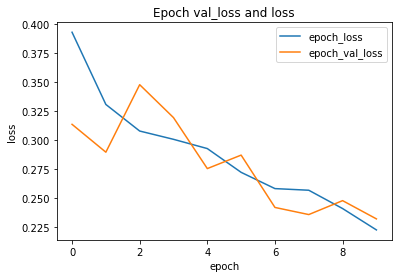

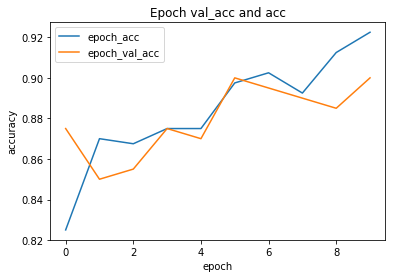

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 10s 24ms/step - loss: 0.3936 - acc: 0.8225 - val_loss: 0.3127 - val_acc: 0.8750
Epoch 2/10
400/400 [==============================] - 3s 6ms/step - loss: 0.3325 - acc: 0.8650 - val_loss: 0.3356 - val_acc: 0.8700
Epoch 3/10
400/400 [==============================] - 3s 7ms/step - loss: 0.3176 - acc: 0.8825 - val_loss: 0.3085 - val_acc: 0.8600
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.3038 - acc: 0.8750 - val_loss: 0.2954 - val_acc: 0.8750
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2925 - acc: 0.8850 - val_loss: 0.3007 - val_acc: 0.8850
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2766 - acc: 0.8975 - val_loss: 0.2687 - val_acc: 0.8850
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2667 - acc: 0.8975 - val_loss: 0.2634 - val_acc: 0.8900
Epoch 8/10
400/400 [========

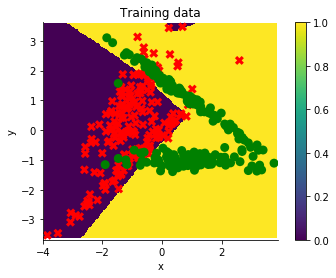

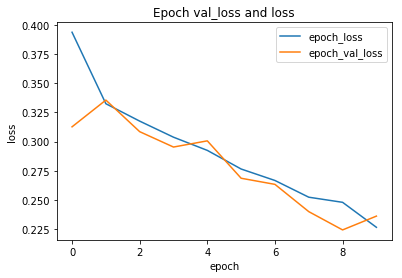

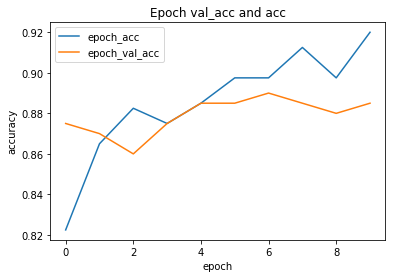


Avg. validation accuracy:0.898


(array([[ 6.84756854e-01,  1.21344045e+00],
        [ 2.65477985e-01, -8.30744385e-01],
        [ 1.18346748e+00,  8.40906891e-01],
        [-5.80205564e-01,  1.90971032e+00],
        [-3.15691448e-01,  1.90027984e+00],
        [-3.38675241e-01,  2.18599111e+00],
        [-1.14554246e-01,  1.70097336e+00],
        [ 1.02735575e+00,  9.99444459e-01],
        [ 6.90088182e-01,  3.46665370e+00],
        [-1.73439407e+00,  5.68351852e-01],
        [-6.36141556e-01,  1.78870373e-01],
        [-2.33903406e-01, -9.22549325e-01],
        [-1.19181144e+00,  2.59930958e+00],
        [ 8.73106827e-01,  1.04839513e+00],
        [ 2.98135036e-01,  4.43167581e-01],
        [-4.15560379e-01, -6.37232073e-01],
        [-1.00426430e+00, -8.12181745e-01],
        [-4.67095185e-01,  1.73027049e+00],
        [ 3.19120517e+00, -4.97730362e-01],
        [-5.05427102e-01,  2.25922912e+00],
        [-9.82064734e-01, -2.67181538e-02],
        [-7.07188277e-01,  1.90105335e+00],
        [-7.95287193e-01, -9.367

In [30]:
run_keras_2d("2", archs(2)[4], 10, trials=5)

Average Validation Accuracy: 89.8%

Dataset: 3 Architecture: 1

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 4s 11ms/step - loss: 1.0633 - acc: 0.0700 - val_loss: 0.8603 - val_acc: 0.1350
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.7041 - acc: 0.5175 - val_loss: 0.5900 - val_acc: 0.8550
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.4869 - acc: 0.9350 - val_loss: 0.4297 - val_acc: 0.9250
Epoch 4/10
400/400 [==============================] - 1s 4ms/step - loss: 0.3605 - acc: 0.9575 - val_loss: 0.3358 - val_acc: 0.9300
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2837 - acc: 0.9600 - val_loss: 0.2763 - val_acc: 0.9350
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2336 - acc: 0.9600 - val_loss: 0.2370 - val_acc: 0.9

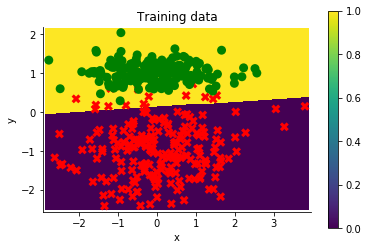

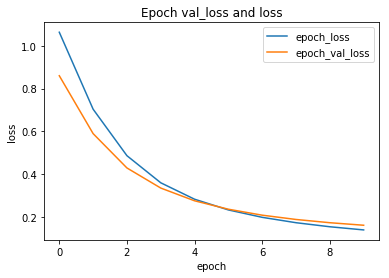

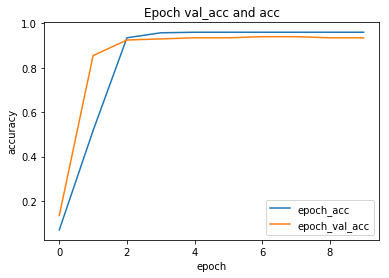

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 5s 12ms/step - loss: 1.1520 - acc: 0.4150 - val_loss: 1.0130 - val_acc: 0.4200
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.7923 - acc: 0.5475 - val_loss: 0.7012 - val_acc: 0.6100
Epoch 3/10
400/400 [==============================] - 1s 4ms/step - loss: 0.5443 - acc: 0.7325 - val_loss: 0.5004 - val_acc: 0.7800
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3886 - acc: 0.8625 - val_loss: 0.3746 - val_acc: 0.8800
Epoch 5/10
400/400 [==============================] - 1s 4ms/step - loss: 0.2943 - acc: 0.9275 - val_loss: 0.2966 - val_acc: 0.9000
Epoch 6/10
400/400 [==============================] - 1s 4ms/step - loss: 0.2362 - acc: 0.9525 - val_loss: 0.2486 - val_acc: 0.9200
Epoch 7/10
400/400 [==============================] - 1s 4ms/step - loss: 0.1991 - acc: 0.9600 - val_loss: 0.2173 - val_acc: 0.9350
Epoch 8/10
400/400 [=========

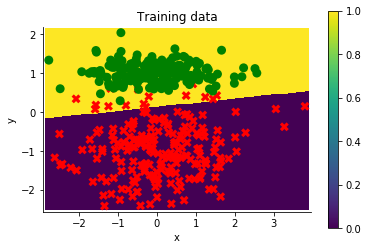

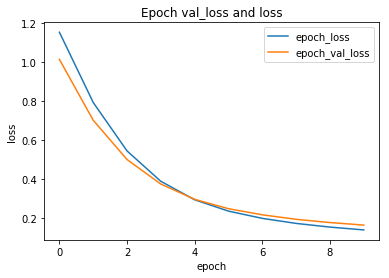

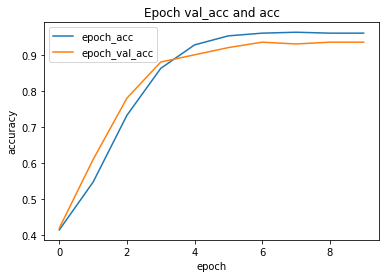

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 5s 12ms/step - loss: 0.3438 - acc: 0.9025 - val_loss: 0.3163 - val_acc: 0.9000
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2426 - acc: 0.9600 - val_loss: 0.2431 - val_acc: 0.9250
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.1904 - acc: 0.9550 - val_loss: 0.2036 - val_acc: 0.9300
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.1601 - acc: 0.9600 - val_loss: 0.1800 - val_acc: 0.9300
Epoch 5/10
400/400 [==============================] - 1s 4ms/step - loss: 0.1403 - acc: 0.9600 - val_loss: 0.1638 - val_acc: 0.9350
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.1265 - acc: 0.9600 - val_loss: 0.1526 - val_acc: 0.9350
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1163 - acc: 0.9600 - val_loss: 0.1441 - val_acc: 0.9400
Epoch 8/10
400/400 [=========

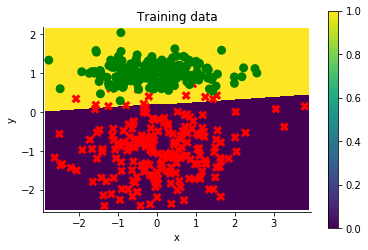

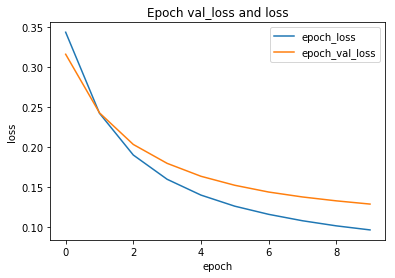

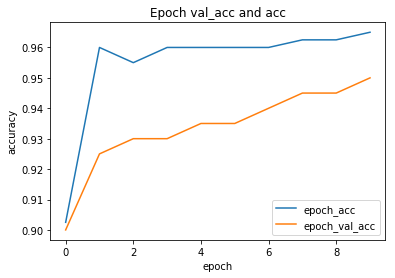

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 5s 12ms/step - loss: 0.5009 - acc: 0.8425 - val_loss: 0.4224 - val_acc: 0.9000
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3357 - acc: 0.9500 - val_loss: 0.3088 - val_acc: 0.9300
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.2509 - acc: 0.9575 - val_loss: 0.2468 - val_acc: 0.9300
Epoch 4/10
400/400 [==============================] - 1s 4ms/step - loss: 0.2024 - acc: 0.9600 - val_loss: 0.2106 - val_acc: 0.9350
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1716 - acc: 0.9600 - val_loss: 0.1864 - val_acc: 0.9350
Epoch 6/10
400/400 [==============================] - 1s 4ms/step - loss: 0.1506 - acc: 0.9600 - val_loss: 0.1699 - val_acc: 0.9350
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1352 - acc: 0.9600 - val_loss: 0.1582 - val_acc: 0.9350
Epoch 8/10
400/400 [=========

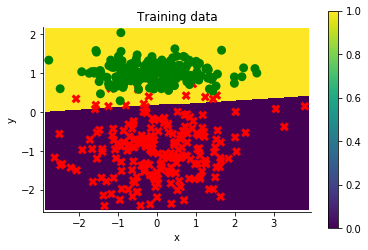

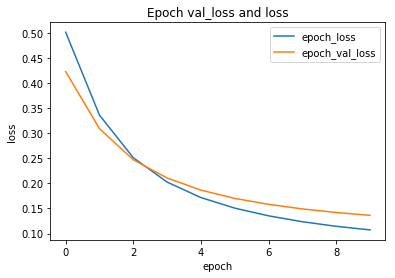

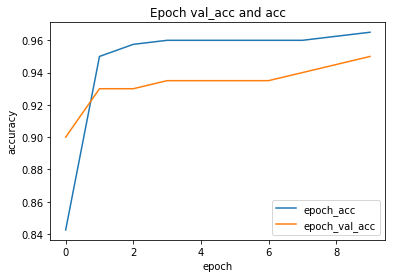

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 5s 12ms/step - loss: 0.5677 - acc: 0.7325 - val_loss: 0.5133 - val_acc: 0.7700
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3812 - acc: 0.8475 - val_loss: 0.3661 - val_acc: 0.8800
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2760 - acc: 0.9100 - val_loss: 0.2839 - val_acc: 0.9000
Epoch 4/10
400/400 [==============================] - 1s 4ms/step - loss: 0.2155 - acc: 0.9425 - val_loss: 0.2338 - val_acc: 0.9150
Epoch 5/10
400/400 [==============================] - 1s 4ms/step - loss: 0.1786 - acc: 0.9625 - val_loss: 0.2029 - val_acc: 0.9300
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1548 - acc: 0.9650 - val_loss: 0.1811 - val_acc: 0.9350
Epoch 7/10
400/400 [==============================] - 1s 4ms/step - loss: 0.1381 - acc: 0.9625 - val_loss: 0.1663 - val_acc: 0.9350
Epoch 8/10
400/400 [=========

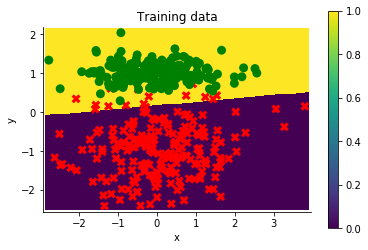

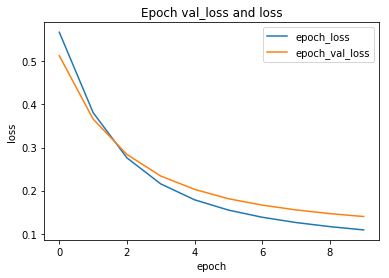

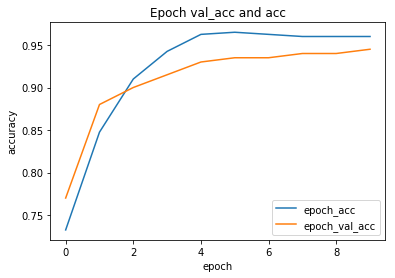


Avg. validation accuracy:0.9430000000000002


(array([[-1.00235028e+00, -7.98731516e-01],
        [-1.64588447e+00, -1.79336505e+00],
        [ 1.29299584e+00,  1.13473841e+00],
        [ 9.05983584e-01,  8.39840174e-01],
        [-8.19227913e-01,  1.13638010e+00],
        [-1.60947813e+00,  1.00125605e+00],
        [-5.14657260e-01,  1.25692322e+00],
        [ 1.27208381e-01,  1.33817514e+00],
        [ 2.02584111e+00,  4.63471587e-03],
        [ 1.25901523e+00,  1.11166169e+00],
        [-9.78487004e-01,  1.33753667e+00],
        [ 4.82659146e-01, -1.18185819e+00],
        [ 3.38379307e-01,  1.31134144e+00],
        [-5.97566850e-01, -2.36224337e-01],
        [-2.69267911e-01, -2.13216450e-02],
        [-6.46615721e-02,  7.29392228e-01],
        [-9.51855250e-01, -2.25623806e+00],
        [ 5.56595729e-01, -9.68298445e-01],
        [ 1.61815412e+00, -1.41098154e+00],
        [ 8.65776779e-01, -1.21762329e+00],
        [-1.00263655e+00,  6.72766167e-01],
        [-7.97818459e-01,  1.73665182e-01],
        [ 7.26888772e-01,  1.015

In [25]:
run_keras_2d("3", archs(2)[0], 10, trials=5)

Average Validation Accuracy: 94.3%

Dataset: 3 Architecture: 2

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 5s 13ms/step - loss: 0.3700 - acc: 0.9425 - val_loss: 0.2426 - val_acc: 0.9350
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1594 - acc: 0.9650 - val_loss: 0.1516 - val_acc: 0.9550
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1000 - acc: 0.9750 - val_loss: 0.1233 - val_acc: 0.9650
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0780 - acc: 0.9775 - val_loss: 0.1128 - val_acc: 0.9700
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0678 - acc: 0.9800 - val_loss: 0.1086 - val_acc: 0.9700
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0612 - acc: 0.9800 - val_loss: 0.1066 - val_acc: 0.9

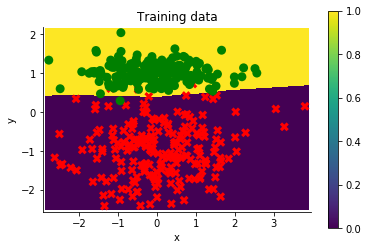

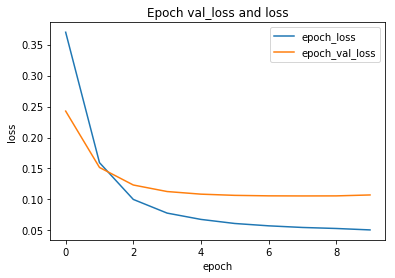

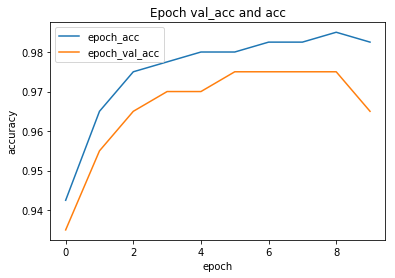

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 6s 14ms/step - loss: 0.7542 - acc: 0.4950 - val_loss: 0.5013 - val_acc: 0.6500
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.4221 - acc: 0.8600 - val_loss: 0.3511 - val_acc: 0.9150
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3025 - acc: 0.9500 - val_loss: 0.2790 - val_acc: 0.9450
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2314 - acc: 0.9625 - val_loss: 0.2311 - val_acc: 0.9500
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1769 - acc: 0.9700 - val_loss: 0.1867 - val_acc: 0.9650
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1301 - acc: 0.9775 - val_loss: 0.1541 - val_acc: 0.9650
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0986 - acc: 0.9825 - val_loss: 0.1331 - val_acc: 0.9700
Epoch 8/10
400/400 [=========

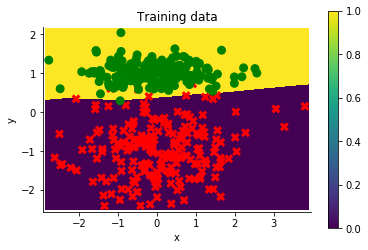

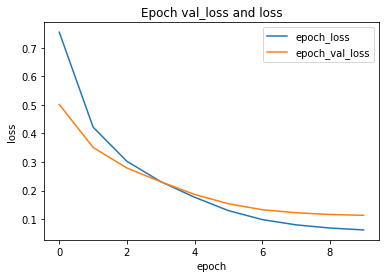

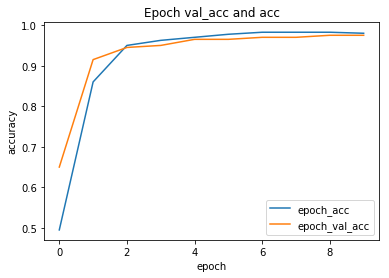

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 6s 14ms/step - loss: 0.9202 - acc: 0.2950 - val_loss: 0.6027 - val_acc: 0.7650
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.4079 - acc: 0.9175 - val_loss: 0.2831 - val_acc: 0.9400
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1934 - acc: 0.9625 - val_loss: 0.1730 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1216 - acc: 0.9700 - val_loss: 0.1374 - val_acc: 0.9600
Epoch 5/10
400/400 [==============================] - 1s 4ms/step - loss: 0.0935 - acc: 0.9725 - val_loss: 0.1229 - val_acc: 0.9650
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0792 - acc: 0.9775 - val_loss: 0.1155 - val_acc: 0.9700
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0705 - acc: 0.9825 - val_loss: 0.1112 - val_acc: 0.9700
Epoch 8/10
400/400 [=========

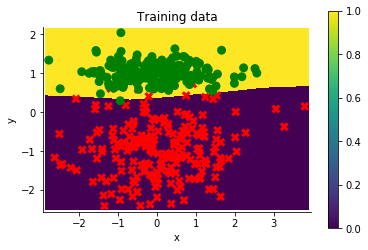

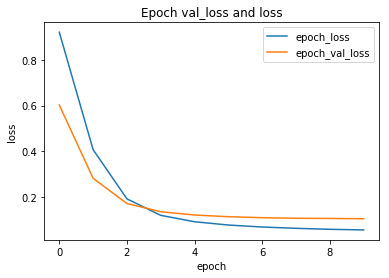

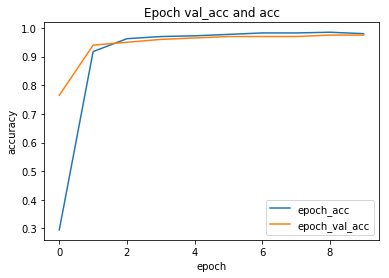

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 6s 15ms/step - loss: 0.3776 - acc: 0.8775 - val_loss: 0.2388 - val_acc: 0.9500
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1559 - acc: 0.9700 - val_loss: 0.1447 - val_acc: 0.9550
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0970 - acc: 0.9750 - val_loss: 0.1209 - val_acc: 0.9550
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0773 - acc: 0.9800 - val_loss: 0.1116 - val_acc: 0.9650
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0676 - acc: 0.9775 - val_loss: 0.1078 - val_acc: 0.9650
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0623 - acc: 0.9800 - val_loss: 0.1057 - val_acc: 0.9700
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0578 - acc: 0.9800 - val_loss: 0.1062 - val_acc: 0.9750
Epoch 8/10
400/400 [=========

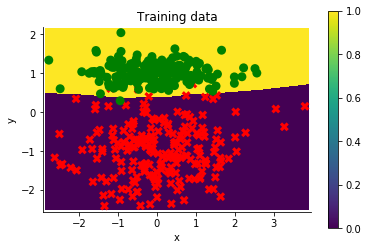

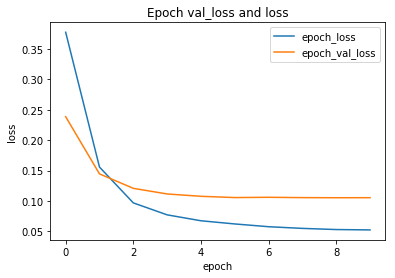

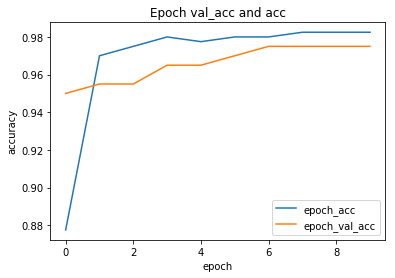

Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 6s 16ms/step - loss: 0.6660 - acc: 0.5675 - val_loss: 0.4549 - val_acc: 0.9050
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2980 - acc: 0.9600 - val_loss: 0.2262 - val_acc: 0.9350
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1494 - acc: 0.9650 - val_loss: 0.1541 - val_acc: 0.9550
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1017 - acc: 0.9650 - val_loss: 0.1290 - val_acc: 0.9550
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0819 - acc: 0.9775 - val_loss: 0.1174 - val_acc: 0.9650
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0710 - acc: 0.9825 - val_loss: 0.1107 - val_acc: 0.9700
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0645 - acc: 0.9800 - val_loss: 0.1078 - val_acc: 0.9750
Epoch 8/10
400/400 [=========

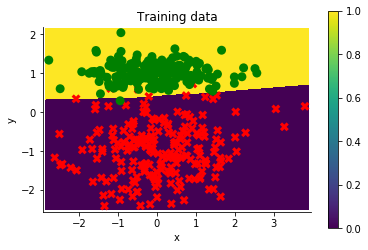

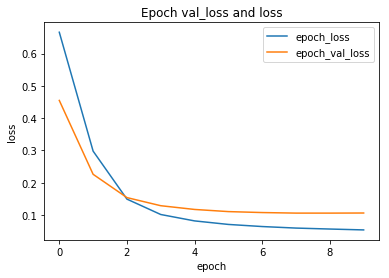

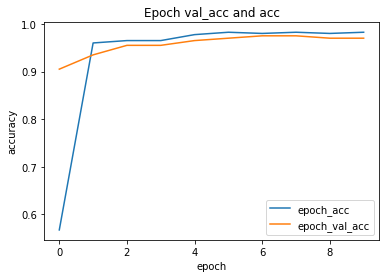


Avg. validation accuracy:0.9720000000000001


(array([[-6.38776473e-01, -1.49137041e+00],
        [ 8.70593920e-02,  1.16291413e+00],
        [ 1.27208381e-01,  1.33817514e+00],
        [-3.23073838e-01, -1.53094630e+00],
        [-4.54727548e-01,  8.28009080e-01],
        [ 1.65836601e-01,  1.04371696e+00],
        [-8.19227913e-01,  1.13638010e+00],
        [-5.01996284e-02,  9.92626678e-01],
        [-2.48121610e+00, -1.36699313e+00],
        [-1.60869714e+00,  1.04500028e+00],
        [ 1.24289721e+00,  3.87016394e-01],
        [-5.62944237e-01, -1.81517397e+00],
        [-1.61810048e-01,  1.17513901e+00],
        [-8.20603757e-01,  7.74998455e-01],
        [-1.44035415e+00,  1.00674819e+00],
        [-4.14832677e-01, -7.61685543e-01],
        [-1.45236904e+00,  4.70368522e-01],
        [ 6.44314599e-01,  9.56992667e-01],
        [-7.02131498e-01, -6.29810247e-01],
        [-2.60818351e-02,  1.01596097e+00],
        [-1.00235028e+00, -7.98731516e-01],
        [-9.22451178e-01,  1.55938011e+00],
        [ 1.64094544e+00, -7.789

In [26]:
run_keras_2d("3", archs(2)[1], 10, trials=5)

Average Validation Accuracy: 97.2%

Dataset: 4 Architecture: 1

Keras FC: dataset= 4
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 17ms/step - loss: 2.5740 - acc: 0.4800 - val_loss: 2.3699 - val_acc: 0.4925
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 2.1446 - acc: 0.4875 - val_loss: 1.9391 - val_acc: 0.4925
Epoch 3/10
400/400 [==============================] - 2s 6ms/step - loss: 1.7249 - acc: 0.4775 - val_loss: 1.5261 - val_acc: 0.4950
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 1.3366 - acc: 0.4775 - val_loss: 1.1600 - val_acc: 0.5050
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0124 - acc: 0.4950 - val_loss: 0.8840 - val_acc: 0.5175
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.8051 - acc: 0.4925 - val_loss: 0.7444 - val_acc: 0.5

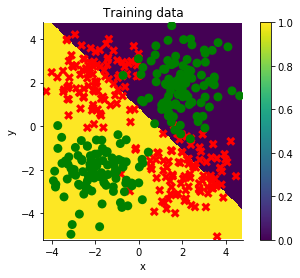

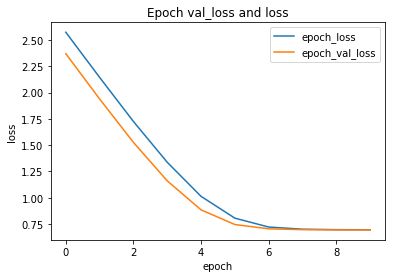

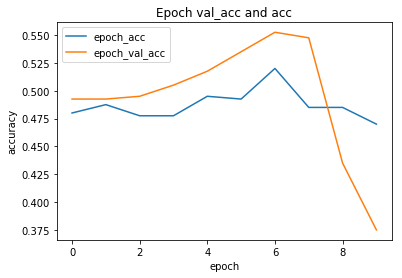

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 5s 14ms/step - loss: 1.5162 - acc: 0.4825 - val_loss: 1.2792 - val_acc: 0.5025
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 1.1715 - acc: 0.4825 - val_loss: 0.9939 - val_acc: 0.5075
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.9139 - acc: 0.4850 - val_loss: 0.8080 - val_acc: 0.5150
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.7664 - acc: 0.4800 - val_loss: 0.7183 - val_acc: 0.5175
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.7107 - acc: 0.5300 - val_loss: 0.6962 - val_acc: 0.5350
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6978 - acc: 0.4750 - val_loss: 0.6934 - val_acc: 0.5050
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.6955 - acc: 0.4525 - val_loss: 0.6931 - val_acc: 0.4550
Epoch 8/10
400/400 [=========

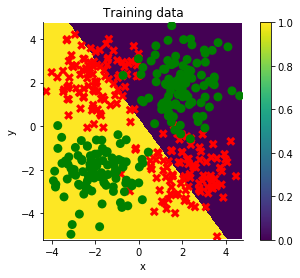

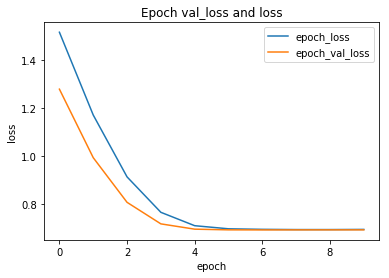

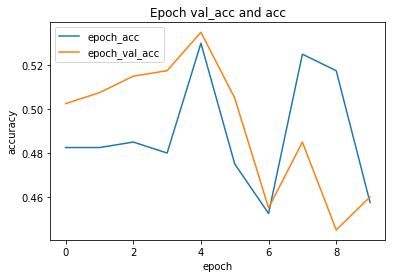

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 6s 15ms/step - loss: 0.8754 - acc: 0.4875 - val_loss: 0.7855 - val_acc: 0.5000
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.7397 - acc: 0.4850 - val_loss: 0.7156 - val_acc: 0.5025
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.7034 - acc: 0.5000 - val_loss: 0.6975 - val_acc: 0.4975
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6966 - acc: 0.4850 - val_loss: 0.6948 - val_acc: 0.4875
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6947 - acc: 0.5075 - val_loss: 0.6937 - val_acc: 0.4925
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6949 - acc: 0.4500 - val_loss: 0.6935 - val_acc: 0.4850
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6955 - acc: 0.4925 - val_loss: 0.6938 - val_acc: 0.5075
Epoch 8/10
400/400 [=========

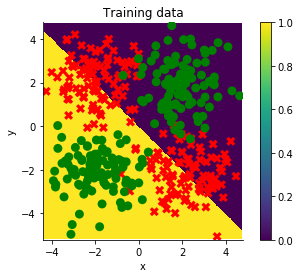

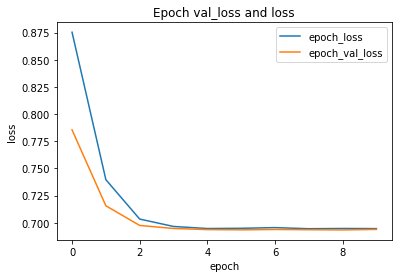

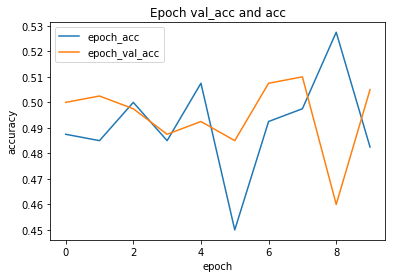

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 17ms/step - loss: 1.1219 - acc: 0.4875 - val_loss: 0.9859 - val_acc: 0.5000
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.8626 - acc: 0.4875 - val_loss: 0.7888 - val_acc: 0.5050
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.7398 - acc: 0.4850 - val_loss: 0.7158 - val_acc: 0.5025
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.7046 - acc: 0.5000 - val_loss: 0.6993 - val_acc: 0.5050
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6961 - acc: 0.4950 - val_loss: 0.6949 - val_acc: 0.4800
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6949 - acc: 0.5700 - val_loss: 0.6936 - val_acc: 0.4550
Epoch 7/10
400/400 [==============================] - 2s 6ms/step - loss: 0.6944 - acc: 0.4650 - val_loss: 0.6934 - val_acc: 0.4400
Epoch 8/10
400/400 [=========

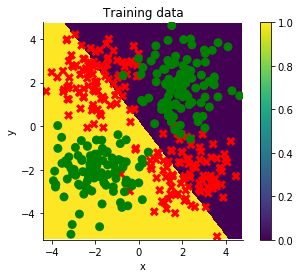

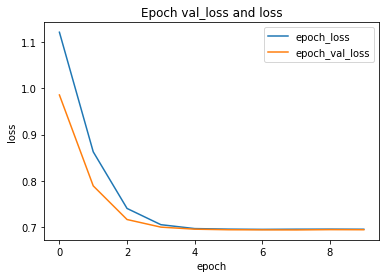

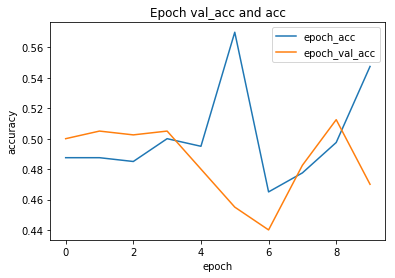

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 17ms/step - loss: 0.9086 - acc: 0.4825 - val_loss: 0.7957 - val_acc: 0.5025
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.7563 - acc: 0.4825 - val_loss: 0.7157 - val_acc: 0.5050
Epoch 3/10
400/400 [==============================] - 2s 6ms/step - loss: 0.7075 - acc: 0.4825 - val_loss: 0.6959 - val_acc: 0.5150
Epoch 4/10
400/400 [==============================] - 2s 6ms/step - loss: 0.6976 - acc: 0.5150 - val_loss: 0.6934 - val_acc: 0.5450
Epoch 5/10
400/400 [==============================] - 2s 6ms/step - loss: 0.6952 - acc: 0.4950 - val_loss: 0.6933 - val_acc: 0.5325
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6950 - acc: 0.4750 - val_loss: 0.6933 - val_acc: 0.4950
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.6946 - acc: 0.4900 - val_loss: 0.6933 - val_acc: 0.5050
Epoch 8/10
400/400 [=========

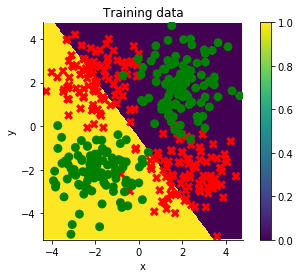

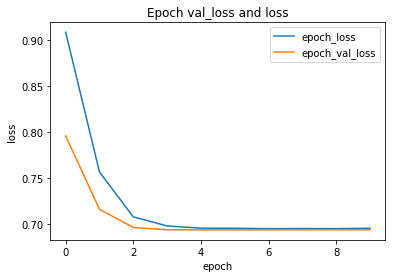

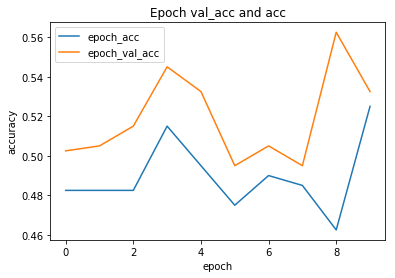


Avg. validation accuracy:0.46849999999999997


(array([[ 2.40591323, -3.62474155],
        [-3.81824128, -2.67352378],
        [-1.64994109, -2.24996185],
        [ 1.98856114,  1.73785544],
        [-2.6258946 , -1.52658098],
        [-0.78263736, -3.73325364],
        [ 3.05123373,  2.9411429 ],
        [-0.7595114 ,  2.29178466],
        [ 1.6475146 , -0.17667474],
        [-0.60570616, -2.62366532],
        [ 1.9328414 ,  0.81284926],
        [ 3.04759181,  3.34861266],
        [-0.83046704, -2.19741878],
        [ 2.36130997, -0.57996825],
        [ 2.79618965, -1.54796574],
        [-0.73170341,  2.33332838],
        [-1.58540484,  1.21626124],
        [ 3.31039454, -2.39740284],
        [ 2.19742706, -0.4738451 ],
        [-2.32533524,  2.40854889],
        [-0.00990719,  3.32797471],
        [-2.7741555 , -2.66732524],
        [-1.98400217,  3.41314959],
        [ 2.03263457, -2.41172373],
        [-1.78002105,  2.73016154],
        [ 1.28513647, -1.9016334 ],
        [ 3.32447555, -1.43664024],
        [-1.73412068,  1.262

In [27]:
run_keras_2d("4", archs(2)[0], 10, trials=5)

Average Validation Accuracy: 46.8%

Dataset: 4 Architecture: 2

Keras FC: dataset= 4
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 17ms/step - loss: 0.4099 - acc: 0.8050 - val_loss: 0.3220 - val_acc: 0.9000
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2675 - acc: 0.9325 - val_loss: 0.2293 - val_acc: 0.9475
Epoch 3/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1989 - acc: 0.9450 - val_loss: 0.1857 - val_acc: 0.9475
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1641 - acc: 0.9525 - val_loss: 0.1625 - val_acc: 0.9500
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1465 - acc: 0.9600 - val_loss: 0.1518 - val_acc: 0.9450
Epoch 6/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1347 - acc: 0.9575 - val_loss: 0.1440 - val_acc: 0.9

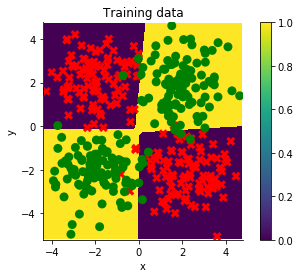

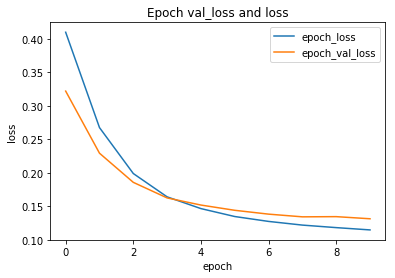

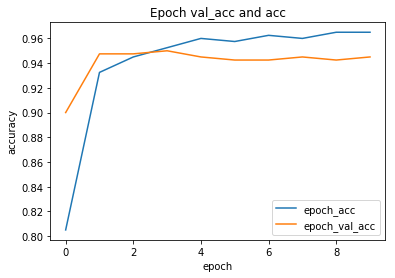

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 18ms/step - loss: 0.8715 - acc: 0.5150 - val_loss: 0.5950 - val_acc: 0.6500
Epoch 2/10
400/400 [==============================] - 2s 6ms/step - loss: 0.4572 - acc: 0.8925 - val_loss: 0.3424 - val_acc: 0.9475
Epoch 3/10
400/400 [==============================] - 2s 6ms/step - loss: 0.2883 - acc: 0.9500 - val_loss: 0.2376 - val_acc: 0.9550
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2103 - acc: 0.9525 - val_loss: 0.1887 - val_acc: 0.9575
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1725 - acc: 0.9625 - val_loss: 0.1645 - val_acc: 0.9500
Epoch 6/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1512 - acc: 0.9575 - val_loss: 0.1474 - val_acc: 0.9550
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1384 - acc: 0.9600 - val_loss: 0.1390 - val_acc: 0.9525
Epoch 8/10
400/400 [=========

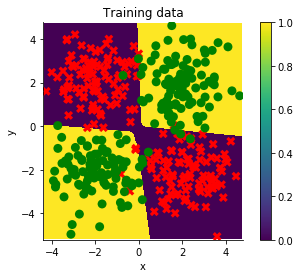

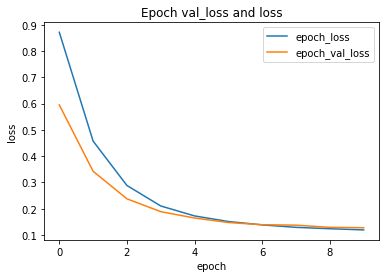

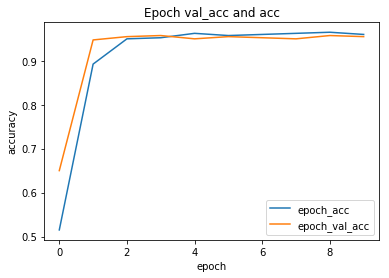

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 17ms/step - loss: 0.5035 - acc: 0.8550 - val_loss: 0.3486 - val_acc: 0.9425
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2792 - acc: 0.9500 - val_loss: 0.2209 - val_acc: 0.9475
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1967 - acc: 0.9550 - val_loss: 0.1748 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1610 - acc: 0.9525 - val_loss: 0.1536 - val_acc: 0.9550
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1438 - acc: 0.9575 - val_loss: 0.1402 - val_acc: 0.9500
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1322 - acc: 0.9550 - val_loss: 0.1336 - val_acc: 0.9525
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1260 - acc: 0.9525 - val_loss: 0.1303 - val_acc: 0.9475
Epoch 8/10
400/400 [=========

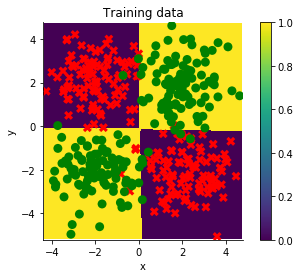

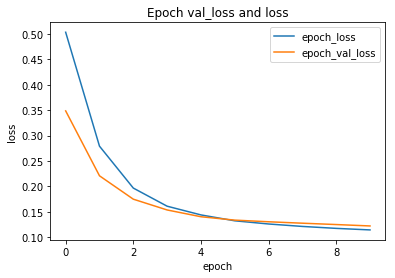

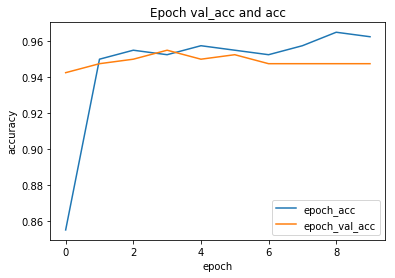

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 18ms/step - loss: 0.6675 - acc: 0.7300 - val_loss: 0.4581 - val_acc: 0.8675
Epoch 2/10
400/400 [==============================] - 2s 6ms/step - loss: 0.3565 - acc: 0.9325 - val_loss: 0.2893 - val_acc: 0.9500
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2449 - acc: 0.9475 - val_loss: 0.2147 - val_acc: 0.9575
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.1930 - acc: 0.9550 - val_loss: 0.1784 - val_acc: 0.9525
Epoch 5/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1641 - acc: 0.9625 - val_loss: 0.1576 - val_acc: 0.9525
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1467 - acc: 0.9625 - val_loss: 0.1490 - val_acc: 0.9500
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1358 - acc: 0.9550 - val_loss: 0.1395 - val_acc: 0.9550
Epoch 8/10
400/400 [=========

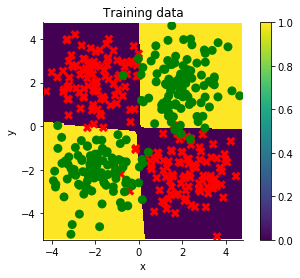

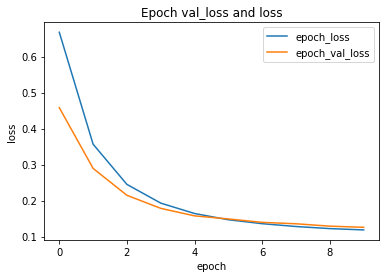

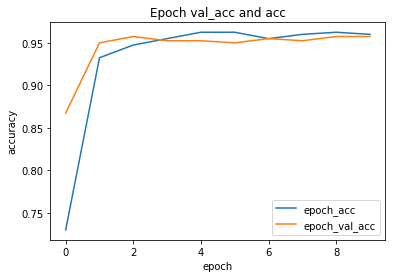

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 7s 18ms/step - loss: 0.5269 - acc: 0.7825 - val_loss: 0.3843 - val_acc: 0.8975
Epoch 2/10
400/400 [==============================] - 2s 6ms/step - loss: 0.3127 - acc: 0.9400 - val_loss: 0.2591 - val_acc: 0.9550
Epoch 3/10
400/400 [==============================] - 2s 6ms/step - loss: 0.2264 - acc: 0.9575 - val_loss: 0.2004 - val_acc: 0.9550
Epoch 4/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1813 - acc: 0.9550 - val_loss: 0.1670 - val_acc: 0.9575
Epoch 5/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1564 - acc: 0.9575 - val_loss: 0.1508 - val_acc: 0.9525
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1417 - acc: 0.9575 - val_loss: 0.1423 - val_acc: 0.9550
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1321 - acc: 0.9550 - val_loss: 0.1347 - val_acc: 0.9550
Epoch 8/10
400/400 [=========

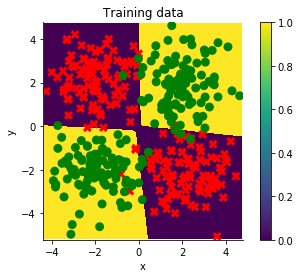

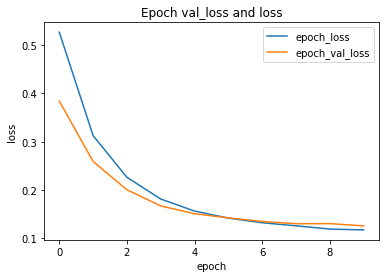

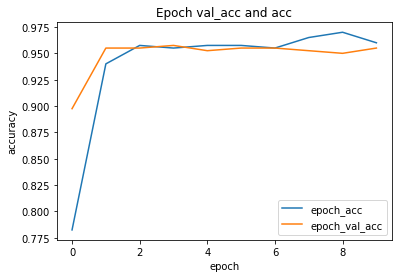


Avg. validation accuracy:0.952


(array([[ 2.83282831, -3.01264973],
        [ 0.9545862 , -2.94432547],
        [ 2.23719151,  2.36293196],
        [ 1.36476774,  1.38623633],
        [ 2.34161403, -2.20167742],
        [ 0.7216015 ,  0.11366605],
        [-1.69318242, -3.57433031],
        [-0.60570616, -2.62366532],
        [ 1.55507096, -2.29849923],
        [-2.06341098,  2.96333347],
        [ 0.17615572, -1.6995463 ],
        [-2.88364188,  2.7968553 ],
        [-1.93516515, -1.81966203],
        [ 1.80286043, -3.10517659],
        [ 1.64921829,  1.89917302],
        [ 2.85473917,  1.07488078],
        [ 2.16453568, -3.32276808],
        [-2.05597053, -2.38339772],
        [-1.80566742, -4.61950757],
        [-0.78238798, -1.60483013],
        [-2.68387736,  0.80764029],
        [-2.53186004, -3.12267378],
        [-2.10339501, -2.26577405],
        [-0.51161171, -3.65950289],
        [ 2.15300715, -2.94826522],
        [ 2.40591323, -3.62474155],
        [-3.83509023, -2.79622673],
        [-2.37210028, -0.902

In [28]:
run_keras_2d("4", archs(2)[1], 10, trials=5)

Average Validation Accuracy: 95.2%

### Part 3

In [31]:
part_3_arch = [Dense(input_dim=2, units=200, activation='relu'),
               Dense(units=200, activation='relu'),
               Dense(units=2, activation="softmax")]

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Train on 400 samples, validate on 200 samples
Epoch 1/100
400/400 [==============================] - 9s 21ms/step - loss: 0.1216 - acc: 0.9525 - val_loss: 0.1288 - val_acc: 0.9550
Epoch 2/100
400/400 [==============================] - 2s 6ms/step - loss: 0.0780 - acc: 0.9775 - val_loss: 0.1229 - val_acc: 0.9650
Epoch 3/100
400/400 [==============================] - 3s 7ms/step - loss: 0.0558 - acc: 0.9775 - val_loss: 0.1348 - val_acc: 0.9700
Epoch 4/100
400/400 [==============================] - 2s 6ms/step - loss: 0.0658 - acc: 0.9775 - val_loss: 0.1103 - val_acc: 0.9650
Epoch 5/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0552 - acc: 0.9825 - val_loss: 0.1244 - val_acc: 0.9750
Epoch 6/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0586 - acc: 0.9800 - val_loss: 0.1294 - val_ac

400/400 [==============================] - 3s 7ms/step - loss: 0.0421 - acc: 0.9900 - val_loss: 0.2092 - val_acc: 0.9700
Epoch 61/100
400/400 [==============================] - 3s 6ms/step - loss: 0.0362 - acc: 0.9900 - val_loss: 0.2259 - val_acc: 0.9700
Epoch 62/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0433 - acc: 0.9850 - val_loss: 0.1876 - val_acc: 0.9750
Epoch 63/100
400/400 [==============================] - 2s 6ms/step - loss: 0.0400 - acc: 0.9850 - val_loss: 0.2018 - val_acc: 0.9700
Epoch 64/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0417 - acc: 0.9800 - val_loss: 0.2337 - val_acc: 0.9750
Epoch 65/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0505 - acc: 0.9875 - val_loss: 0.2100 - val_acc: 0.9700
Epoch 66/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0396 - acc: 0.9900 - val_loss: 0.2064 - val_acc: 0.9700
Epoch 67/100
400/400 [==============================] - 2s 5ms/step - loss:

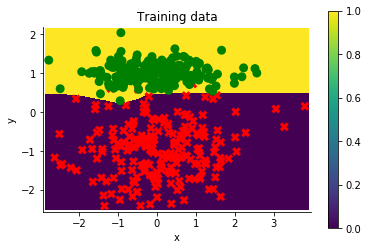

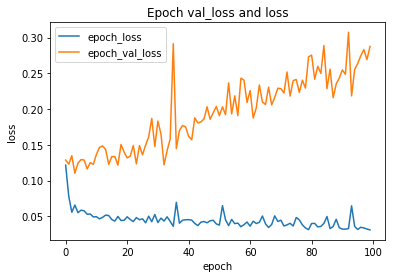

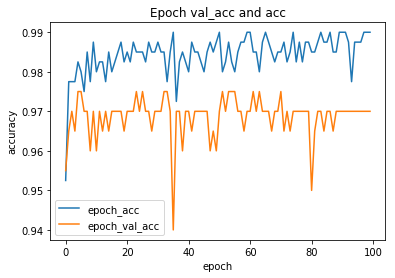


Avg. validation accuracy:0.97


(array([[-6.37157920e-01, -4.27618581e-01],
        [ 7.17487011e-01,  1.40977888e+00],
        [-8.72351116e-01,  6.33199395e-01],
        [ 3.43319427e-01, -1.58022728e+00],
        [-3.55639647e-02,  1.26847710e+00],
        [ 7.58980601e-01,  1.17926749e+00],
        [ 8.49637322e-01, -1.29314599e-01],
        [ 4.69102326e-01,  1.00753548e+00],
        [-8.76150821e-01,  9.38246134e-01],
        [ 4.20037118e-01,  1.03254396e+00],
        [ 1.26251243e+00, -1.33798222e+00],
        [-1.91870264e+00, -9.72408379e-01],
        [-1.22825580e+00,  6.62205401e-01],
        [-5.12638604e-01, -1.66997181e+00],
        [-7.36329438e-01,  8.31344915e-01],
        [-9.19477385e-01, -8.83574263e-01],
        [-1.33650871e-01, -9.32036395e-01],
        [-3.92251702e-01, -5.99675561e-01],
        [ 2.97793904e-01,  9.73662817e-01],
        [ 1.09315404e+00,  1.25350731e+00],
        [-6.36989768e-01,  8.95222556e-01],
        [ 3.31873096e-01,  1.16156475e+00],
        [-1.24458639e+00,  7.306

In [32]:
run_keras_2d("3", part_3_arch, 100, trials=1)

### Part 5

Architecture: 1

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 13s 33ms/step - loss: 0.7430 - acc: 0.8200 - val_loss: 0.6501 - val_acc: 0.8700
Epoch 2/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5888 - acc: 0.8600 - val_loss: 0.5400 - val_acc: 0.8950
Epoch 3/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5005 - acc: 0.8900 - val_loss: 0.4747 - val_acc: 0.9025
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4459 - acc: 0.8975 - val_loss: 0.4317 - val_acc: 0.9025
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4104 - acc: 0.9000 - val_loss: 0.4035 - val_acc: 0.9025
Epoch 6/10
400/400 [==============================] - 3s 9ms/step - loss: 0.3856 - acc: 0.9050 - val_loss: 0.3829 - val_acc: 0.9050
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.3680 -

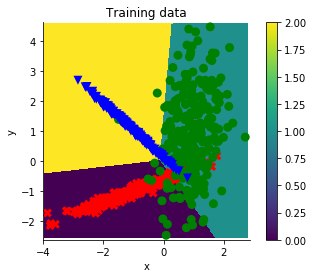

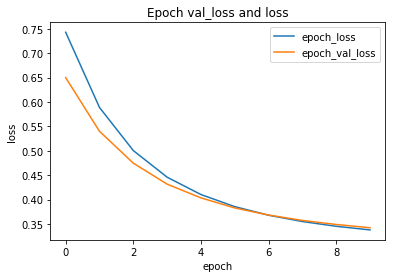

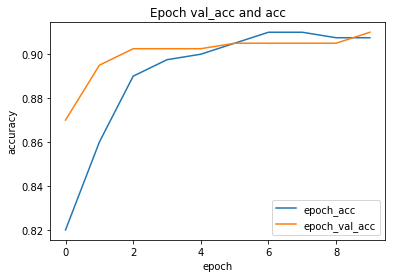

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 12s 31ms/step - loss: 1.4180 - acc: 0.2375 - val_loss: 1.2642 - val_acc: 0.3500
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 1.0416 - acc: 0.4725 - val_loss: 0.9419 - val_acc: 0.5875
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.8050 - acc: 0.7275 - val_loss: 0.7429 - val_acc: 0.8100
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.6588 - acc: 0.8625 - val_loss: 0.6177 - val_acc: 0.8850
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5657 - acc: 0.8875 - val_loss: 0.5387 - val_acc: 0.8975
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5034 - acc: 0.8975 - val_loss: 0.4847 - val_acc: 0.9000
Epoch 7/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4595 - acc: 0.9000 - val_loss: 0.4456 - val_acc: 0.9000
Epoch 8/10
400/400 [=======

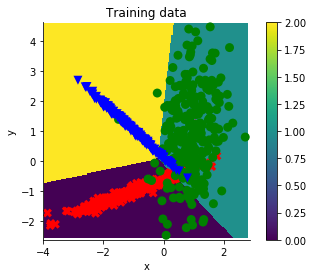

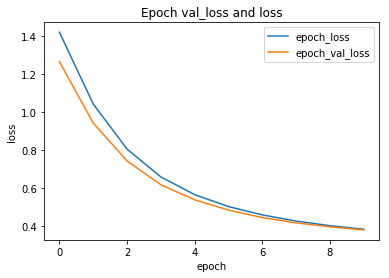

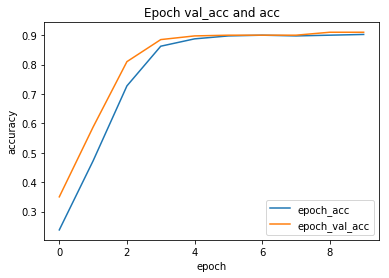

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 13s 32ms/step - loss: 1.9928 - acc: 0.0800 - val_loss: 1.6521 - val_acc: 0.0800
Epoch 2/10
400/400 [==============================] - 3s 7ms/step - loss: 1.4791 - acc: 0.1375 - val_loss: 1.2265 - val_acc: 0.3600
Epoch 3/10
400/400 [==============================] - 3s 7ms/step - loss: 1.1142 - acc: 0.5775 - val_loss: 0.9352 - val_acc: 0.6675
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.8599 - acc: 0.6900 - val_loss: 0.7393 - val_acc: 0.7525
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.6864 - acc: 0.7400 - val_loss: 0.6106 - val_acc: 0.8225
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5740 - acc: 0.8025 - val_loss: 0.5296 - val_acc: 0.8550
Epoch 7/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5014 - acc: 0.8425 - val_loss: 0.4756 - val_acc: 0.8650
Epoch 8/10
400/400 [========

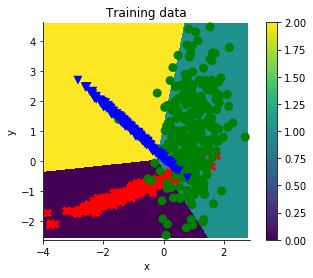

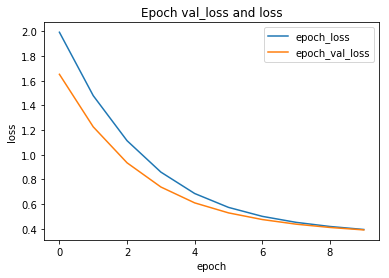

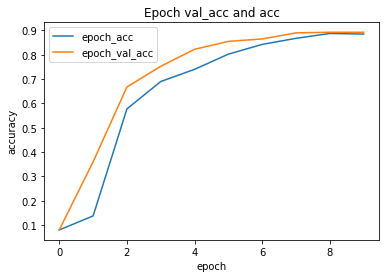

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 13s 33ms/step - loss: 1.3648 - acc: 0.3150 - val_loss: 1.1488 - val_acc: 0.5825
Epoch 2/10
400/400 [==============================] - 3s 7ms/step - loss: 1.0437 - acc: 0.5975 - val_loss: 0.8839 - val_acc: 0.6250
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.8115 - acc: 0.6350 - val_loss: 0.6933 - val_acc: 0.6900
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.6494 - acc: 0.7300 - val_loss: 0.5706 - val_acc: 0.8075
Epoch 5/10
400/400 [==============================] - 3s 8ms/step - loss: 0.5449 - acc: 0.8150 - val_loss: 0.4970 - val_acc: 0.8525
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4791 - acc: 0.8700 - val_loss: 0.4489 - val_acc: 0.8900
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.4363 - acc: 0.8850 - val_loss: 0.4172 - val_acc: 0.8925
Epoch 8/10
400/400 [========

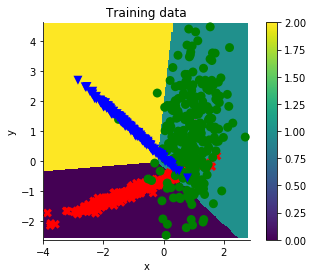

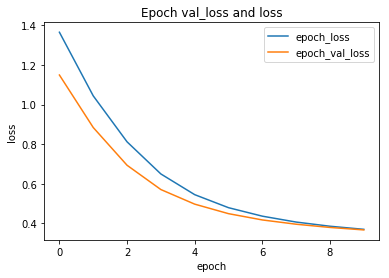

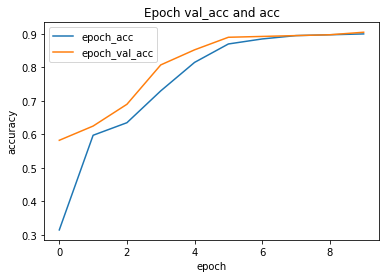

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 13s 33ms/step - loss: 1.4369 - acc: 0.3825 - val_loss: 1.2397 - val_acc: 0.3850
Epoch 2/10
400/400 [==============================] - 3s 7ms/step - loss: 1.0403 - acc: 0.4750 - val_loss: 0.9221 - val_acc: 0.5400
Epoch 3/10
400/400 [==============================] - 3s 7ms/step - loss: 0.7986 - acc: 0.6500 - val_loss: 0.7290 - val_acc: 0.8150
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.6511 - acc: 0.8425 - val_loss: 0.6094 - val_acc: 0.8775
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5585 - acc: 0.8825 - val_loss: 0.5318 - val_acc: 0.8925
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 0.4961 - acc: 0.8875 - val_loss: 0.4793 - val_acc: 0.8925
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.4525 - acc: 0.8950 - val_loss: 0.4417 - val_acc: 0.8950
Epoch 8/10
400/400 [========

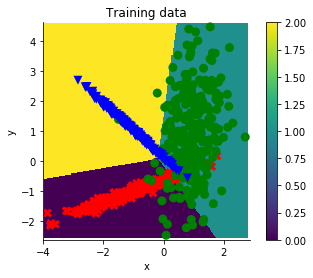

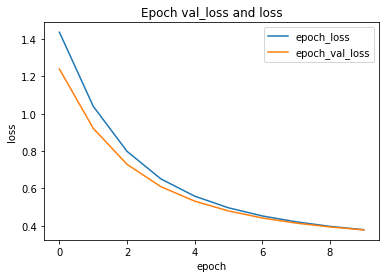

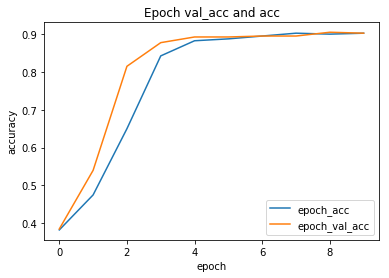


Avg. validation accuracy:0.9039999999999999


(array([[ 1.60559239,  2.68257948],
        [-1.24210537, -1.10790644],
        [-2.09938534,  2.00984551],
        ...,
        [-0.09547749, -0.73329325],
        [ 1.56124283,  1.39117801],
        [-0.53188613, -0.86664192]]),
 array([1., 0., 2., 1., 0., 2., 2., 1., 0., 2., 2., 2., 1., 0., 1., 0., 1.,
        1., 2., 1., 2., 2., 0., 0., 2., 1., 1., 0., 1., 1., 0., 1., 2., 0.,
        0., 0., 1., 0., 1., 2., 0., 1., 1., 0., 0., 2., 0., 0., 1., 2., 2.,
        2., 0., 0., 1., 0., 0., 2., 2., 0., 1., 2., 0., 0., 0., 0., 2., 1.,
        1., 0., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 0., 2., 1., 2.,
        2., 0., 0., 0., 1., 1., 0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 0., 2., 0., 2., 1.,
        1., 2., 0., 2., 0., 2., 1., 0., 2., 0., 0., 1., 1., 2., 0., 0., 2.,
        0., 2., 2., 1., 0., 1., 2., 0., 1., 2., 2., 0., 0., 2., 2., 0., 1.,
        2., 0., 0., 0., 0., 1., 2., 1., 0., 2., 1., 2., 1., 2., 1., 1., 1.,
        2

In [41]:
run_keras_2d("3class", archs(3)[0], 10, split=0.5, trials=5)

Average Validation Accuracy: 90.4%

Architecture: 2

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 13s 32ms/step - loss: 0.6886 - acc: 0.7975 - val_loss: 0.4703 - val_acc: 0.9225
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4040 - acc: 0.8875 - val_loss: 0.3331 - val_acc: 0.9225
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.3185 - acc: 0.9100 - val_loss: 0.2775 - val_acc: 0.9175
Epoch 4/10
400/400 [==============================] - 4s 9ms/step - loss: 0.2799 - acc: 0.9100 - val_loss: 0.2510 - val_acc: 0.9200
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2576 - acc: 0.9125 - val_loss: 0.2346 - val_acc: 0.9200
Epoch 6/10
400/400 [==============================] - 5s 12ms/step - loss: 0.2416 - acc: 0.9150 - val_loss: 0.2217 - val_acc: 0.9250
Epoch 7/10
400/400 [==============================] - 5s 12ms/step - loss: 0.23

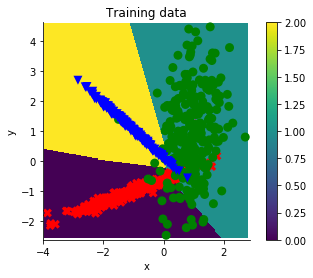

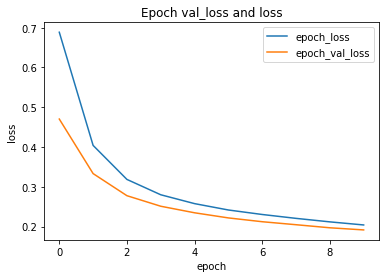

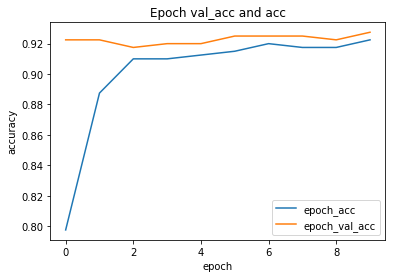

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 13s 33ms/step - loss: 1.0207 - acc: 0.6450 - val_loss: 0.7328 - val_acc: 0.7725
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.5559 - acc: 0.8725 - val_loss: 0.4349 - val_acc: 0.9175
Epoch 3/10
400/400 [==============================] - 3s 7ms/step - loss: 0.3620 - acc: 0.9150 - val_loss: 0.3200 - val_acc: 0.9250
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.2884 - acc: 0.9175 - val_loss: 0.2696 - val_acc: 0.9300
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.2533 - acc: 0.9225 - val_loss: 0.2412 - val_acc: 0.9300
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 0.2321 - acc: 0.9250 - val_loss: 0.2242 - val_acc: 0.9350
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2176 - acc: 0.9325 - val_loss: 0.2124 - val_acc: 0.9300
Epoch 8/10
400/400 [========

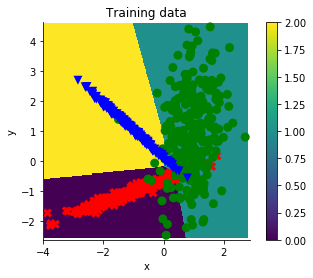

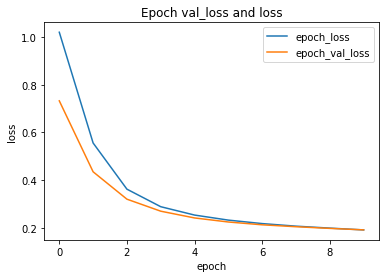

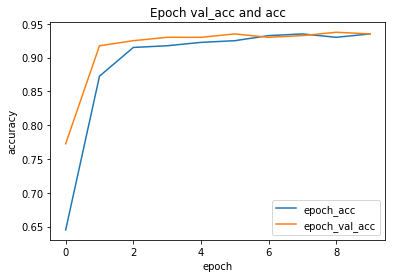

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 14s 35ms/step - loss: 1.1049 - acc: 0.4650 - val_loss: 0.6701 - val_acc: 0.9225
Epoch 2/10
400/400 [==============================] - 3s 7ms/step - loss: 0.5255 - acc: 0.9000 - val_loss: 0.3997 - val_acc: 0.9200
Epoch 3/10
400/400 [==============================] - 3s 7ms/step - loss: 0.3739 - acc: 0.9100 - val_loss: 0.3128 - val_acc: 0.9200
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 0.3158 - acc: 0.9150 - val_loss: 0.2714 - val_acc: 0.9175
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.2845 - acc: 0.9175 - val_loss: 0.2501 - val_acc: 0.9200
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 0.2638 - acc: 0.9150 - val_loss: 0.2345 - val_acc: 0.9225
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2474 - acc: 0.9200 - val_loss: 0.2233 - val_acc: 0.9250
Epoch 8/10
400/400 [========

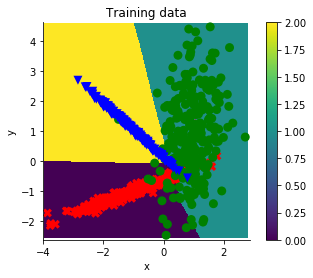

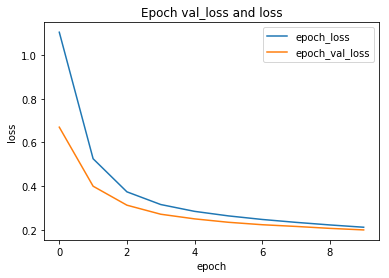

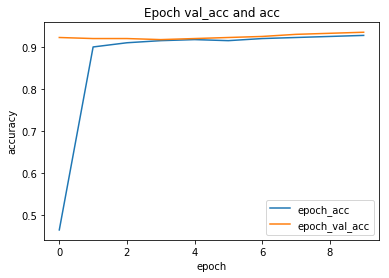

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 14s 34ms/step - loss: 0.8574 - acc: 0.6475 - val_loss: 0.6349 - val_acc: 0.9275
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.5050 - acc: 0.9125 - val_loss: 0.4121 - val_acc: 0.9250
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.3594 - acc: 0.9125 - val_loss: 0.3193 - val_acc: 0.9250
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2984 - acc: 0.9150 - val_loss: 0.2759 - val_acc: 0.9300
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 0.2670 - acc: 0.9150 - val_loss: 0.2512 - val_acc: 0.9300
Epoch 6/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2470 - acc: 0.9225 - val_loss: 0.2346 - val_acc: 0.9325
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2323 - acc: 0.9250 - val_loss: 0.2217 - val_acc: 0.9325
Epoch 8/10
400/400 [========

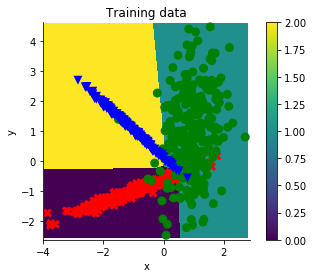

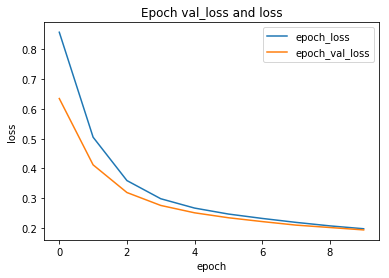

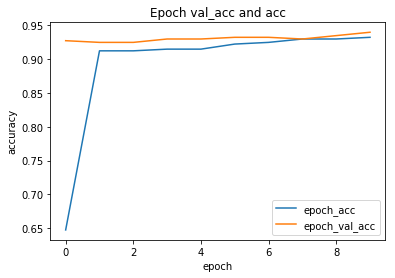

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 14s 36ms/step - loss: 0.9481 - acc: 0.3950 - val_loss: 0.7297 - val_acc: 0.6475
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.5755 - acc: 0.8775 - val_loss: 0.4706 - val_acc: 0.9325
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.3840 - acc: 0.9250 - val_loss: 0.3259 - val_acc: 0.9325
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2837 - acc: 0.9300 - val_loss: 0.2567 - val_acc: 0.9375
Epoch 5/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2370 - acc: 0.9325 - val_loss: 0.2237 - val_acc: 0.9375
Epoch 6/10
400/400 [==============================] - 4s 9ms/step - loss: 0.2108 - acc: 0.9375 - val_loss: 0.2051 - val_acc: 0.9375
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1954 - acc: 0.9375 - val_loss: 0.1923 - val_acc: 0.9375
Epoch 8/10
400/400 [========

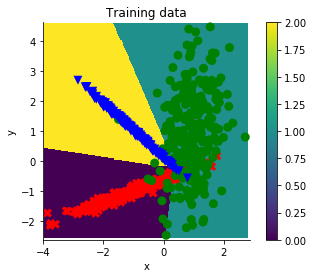

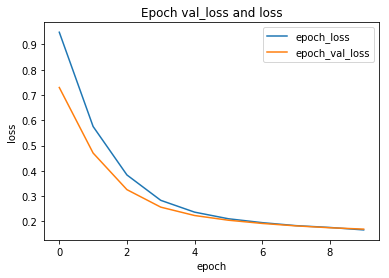

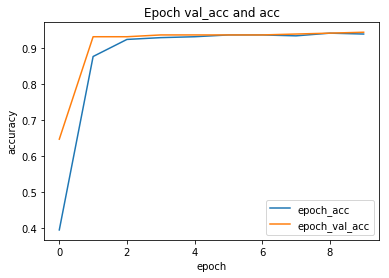


Avg. validation accuracy:0.9365


(array([[-1.3758826 ,  1.39017549],
        [-0.67883299,  0.73094349],
        [ 1.04263092, -0.12960768],
        ...,
        [-0.39923057, -0.65240869],
        [ 0.36399206, -0.12539262],
        [ 0.24173685,  0.61723694]]),
 array([2., 2., 0., 2., 1., 1., 0., 2., 0., 2., 2., 0., 2., 1., 1., 0., 0.,
        1., 1., 2., 2., 0., 0., 0., 0., 2., 2., 2., 0., 1., 0., 0., 2., 0.,
        1., 0., 2., 2., 2., 2., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 2.,
        1., 0., 1., 1., 0., 0., 0., 2., 2., 1., 1., 1., 0., 0., 2., 1., 2.,
        0., 1., 1., 2., 2., 0., 0., 1., 0., 2., 1., 2., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 2., 0., 2., 0., 2., 0., 0., 2., 2., 2., 2., 1., 2.,
        2., 0., 2., 1., 0., 0., 0., 0., 0., 1., 2., 1., 2., 1., 0., 2., 2.,
        1., 2., 0., 1., 0., 1., 1., 1., 2., 1., 0., 2., 2., 2., 0., 2., 1.,
        0., 2., 1., 1., 2., 0., 2., 0., 1., 2., 1., 2., 1., 0., 2., 0., 1.,
        0., 0., 2., 2., 2., 0., 0., 1., 1., 0., 1., 0., 0., 2., 2., 1., 1.,
        1

In [42]:
run_keras_2d("3class", archs(3)[1], 10, split=0.5, trials=5)

Average Validation Accuracy: 93.7%

Architecture: 3

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 14s 36ms/step - loss: 0.4650 - acc: 0.9150 - val_loss: 0.2511 - val_acc: 0.9300
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2402 - acc: 0.9175 - val_loss: 0.2026 - val_acc: 0.9400
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2029 - acc: 0.9300 - val_loss: 0.1818 - val_acc: 0.9525
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1767 - acc: 0.9425 - val_loss: 0.1718 - val_acc: 0.9525
Epoch 5/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1611 - acc: 0.9450 - val_loss: 0.1639 - val_acc: 0.9600
Epoch 6/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1512 - acc: 0.9525 - val_loss: 0.1564 - val_acc: 0.9600
Epoch 7/10
400/400 [==============================] - 3s 9ms/step - loss: 0.1428 -

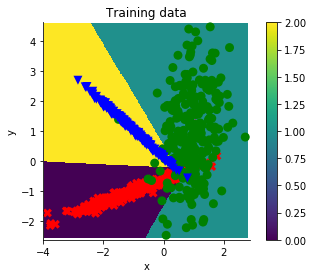

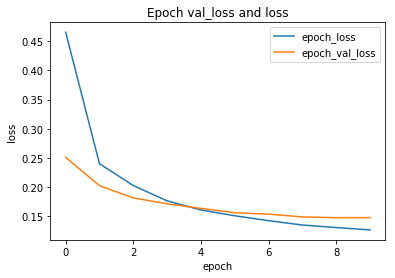

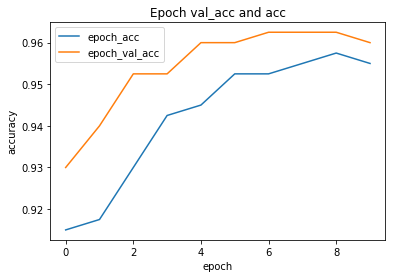

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 15s 37ms/step - loss: 0.5411 - acc: 0.8450 - val_loss: 0.2712 - val_acc: 0.9250
Epoch 2/10
400/400 [==============================] - 3s 9ms/step - loss: 0.2566 - acc: 0.9125 - val_loss: 0.2097 - val_acc: 0.9425
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2096 - acc: 0.9325 - val_loss: 0.1849 - val_acc: 0.9475
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1823 - acc: 0.9375 - val_loss: 0.1702 - val_acc: 0.9550
Epoch 5/10
400/400 [==============================] - 4s 11ms/step - loss: 0.1634 - acc: 0.9450 - val_loss: 0.1625 - val_acc: 0.9575
Epoch 6/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1519 - acc: 0.9525 - val_loss: 0.1565 - val_acc: 0.9600
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1417 - acc: 0.9525 - val_loss: 0.1497 - val_acc: 0.9625
Epoch 8/10
400/400 [=======

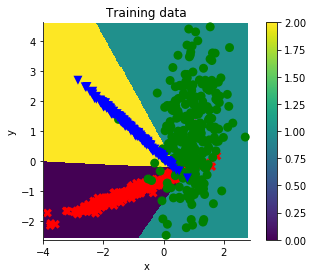

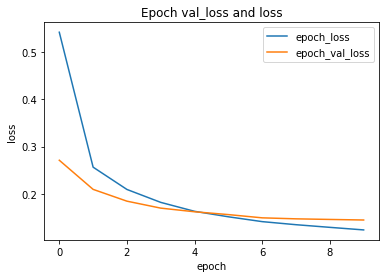

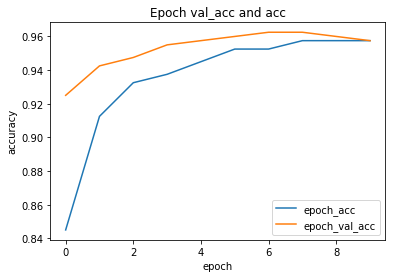

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 16s 40ms/step - loss: 0.4902 - acc: 0.8975 - val_loss: 0.2597 - val_acc: 0.9250
Epoch 2/10
400/400 [==============================] - 3s 9ms/step - loss: 0.2504 - acc: 0.9175 - val_loss: 0.2058 - val_acc: 0.9375
Epoch 3/10
400/400 [==============================] - 3s 9ms/step - loss: 0.2082 - acc: 0.9275 - val_loss: 0.1864 - val_acc: 0.9450
Epoch 4/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1840 - acc: 0.9400 - val_loss: 0.1730 - val_acc: 0.9525
Epoch 5/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1679 - acc: 0.9400 - val_loss: 0.1639 - val_acc: 0.9575
Epoch 6/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1560 - acc: 0.9475 - val_loss: 0.1565 - val_acc: 0.9600
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1438 - acc: 0.9475 - val_loss: 0.1548 - val_acc: 0.9575
Epoch 8/10
400/400 [========

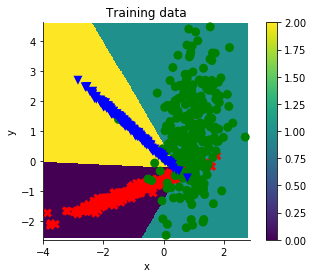

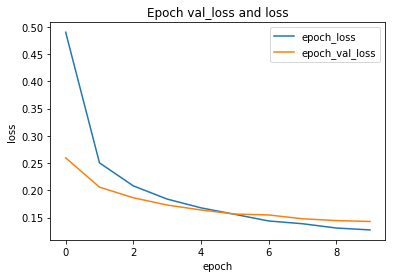

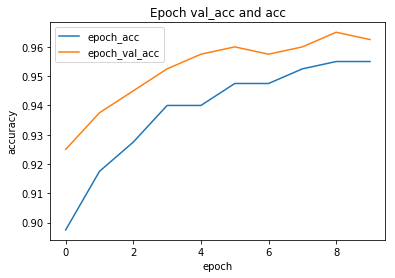

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 16s 39ms/step - loss: 0.4809 - acc: 0.8900 - val_loss: 0.2549 - val_acc: 0.9300
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2420 - acc: 0.9250 - val_loss: 0.2051 - val_acc: 0.9350
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1994 - acc: 0.9350 - val_loss: 0.1837 - val_acc: 0.9475
Epoch 4/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1780 - acc: 0.9375 - val_loss: 0.1714 - val_acc: 0.9525
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1630 - acc: 0.9425 - val_loss: 0.1635 - val_acc: 0.9575
Epoch 6/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1513 - acc: 0.9450 - val_loss: 0.1579 - val_acc: 0.9575
Epoch 7/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1433 - acc: 0.9500 - val_loss: 0.1538 - val_acc: 0.9600
Epoch 8/10
400/400 [=======

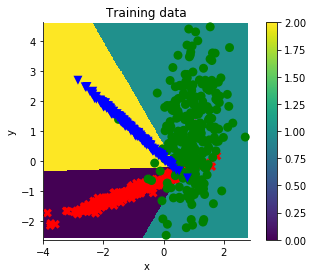

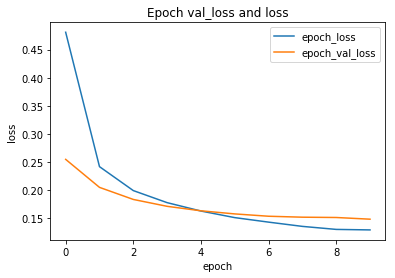

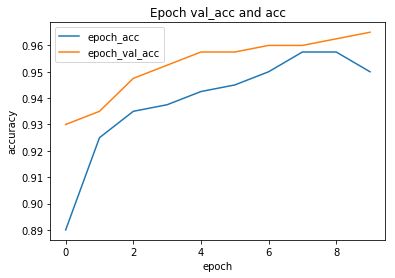

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 17s 42ms/step - loss: 0.5338 - acc: 0.8550 - val_loss: 0.2674 - val_acc: 0.9300
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2508 - acc: 0.9225 - val_loss: 0.2089 - val_acc: 0.9350
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.2039 - acc: 0.9325 - val_loss: 0.1887 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 3s 9ms/step - loss: 0.1805 - acc: 0.9450 - val_loss: 0.1728 - val_acc: 0.9475
Epoch 5/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1636 - acc: 0.9450 - val_loss: 0.1634 - val_acc: 0.9550
Epoch 6/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1491 - acc: 0.9525 - val_loss: 0.1592 - val_acc: 0.9600
Epoch 7/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1418 - acc: 0.9525 - val_loss: 0.1547 - val_acc: 0.9600
Epoch 8/10
400/400 [=======

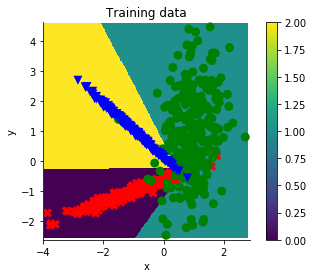

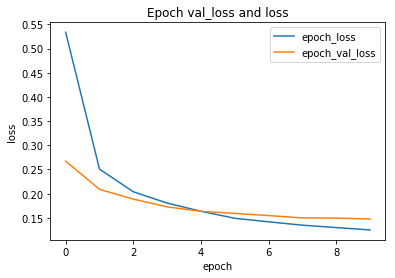

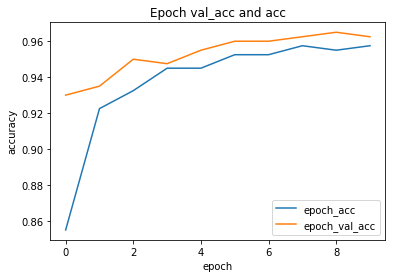


Avg. validation accuracy:0.9615


(array([[ 0.32499805, -0.56117678],
        [ 1.28286049, -0.00457453],
        [-1.83287283,  1.83904525],
        ...,
        [-0.98935186, -0.9525287 ],
        [-0.97638344,  1.04633219],
        [-1.47571385,  1.46051912]]),
 array([0., 1., 2., 0., 1., 1., 2., 2., 0., 0., 2., 0., 0., 0., 1., 1., 2.,
        0., 2., 1., 2., 1., 1., 0., 0., 1., 0., 1., 2., 2., 1., 1., 1., 1.,
        1., 2., 2., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 0., 1., 2., 1.,
        0., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 1., 0., 2., 1., 1., 2.,
        2., 1., 0., 2., 1., 0., 1., 2., 2., 2., 2., 1., 1., 2., 1., 0., 0.,
        0., 0., 1., 2., 0., 1., 0., 2., 2., 2., 2., 0., 2., 0., 0., 1., 1.,
        0., 0., 2., 2., 1., 1., 1., 2., 0., 2., 0., 0., 0., 1., 2., 2., 1.,
        2., 1., 1., 2., 2., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 2., 0., 2., 2., 1., 2., 2., 1., 1., 1., 2., 2., 0., 0., 0.,
        2., 1., 1., 1., 1., 0., 1., 1., 1., 0., 2., 2., 2., 1., 0., 2., 2.,
        0

In [43]:
run_keras_2d("3class", archs(3)[2], 10, split=0.5, trials=5)

Average Validation Accuracy: 96.2%

Architecture: 4

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 16s 41ms/step - loss: 0.7274 - acc: 0.7375 - val_loss: 0.4318 - val_acc: 0.9150
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2974 - acc: 0.9300 - val_loss: 0.2621 - val_acc: 0.9300
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.2204 - acc: 0.9300 - val_loss: 0.2302 - val_acc: 0.9300
Epoch 4/10
400/400 [==============================] - 3s 9ms/step - loss: 0.2010 - acc: 0.9400 - val_loss: 0.2067 - val_acc: 0.9275
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1889 - acc: 0.9450 - val_loss: 0.1937 - val_acc: 0.9300
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1811 - acc: 0.9475 - val_loss: 0.1826 - val_acc: 0.9400
Epoch 7/10
400/400 [==============================] - 4s 10ms/step - loss: 0.17

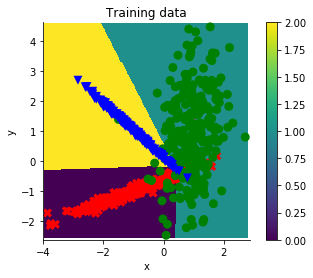

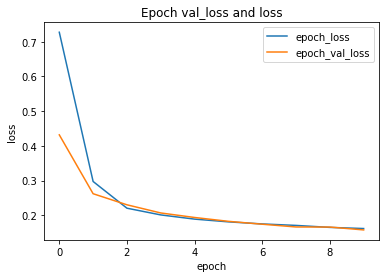

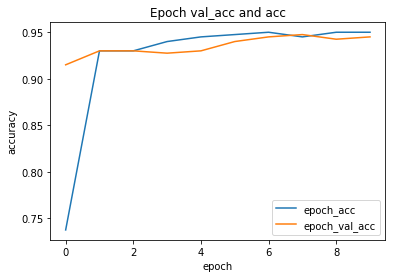

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 16s 39ms/step - loss: 0.7219 - acc: 0.7750 - val_loss: 0.5070 - val_acc: 0.8950
Epoch 2/10
400/400 [==============================] - 4s 11ms/step - loss: 0.3608 - acc: 0.9250 - val_loss: 0.2886 - val_acc: 0.9075
Epoch 3/10
400/400 [==============================] - 7s 16ms/step - loss: 0.2405 - acc: 0.9275 - val_loss: 0.2430 - val_acc: 0.9175
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2105 - acc: 0.9300 - val_loss: 0.2223 - val_acc: 0.9250
Epoch 5/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1956 - acc: 0.9325 - val_loss: 0.2034 - val_acc: 0.9300
Epoch 6/10
400/400 [==============================] - 5s 14ms/step - loss: 0.1874 - acc: 0.9400 - val_loss: 0.1933 - val_acc: 0.9325
Epoch 7/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1794 - acc: 0.9475 - val_loss: 0.1851 - val_acc: 0.9350
Epoch 8/10
400/400 [===

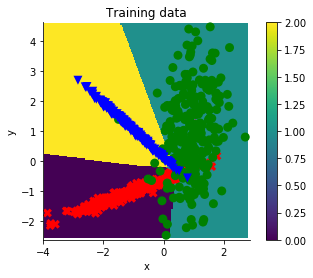

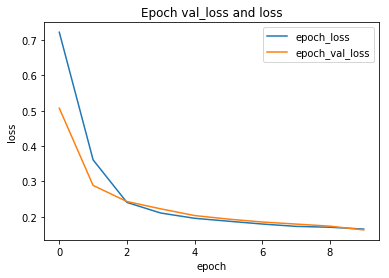

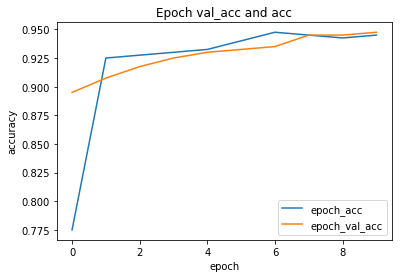

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 19s 47ms/step - loss: 0.6575 - acc: 0.7725 - val_loss: 0.3710 - val_acc: 0.9150
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2695 - acc: 0.9350 - val_loss: 0.2522 - val_acc: 0.9175
Epoch 3/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2124 - acc: 0.9350 - val_loss: 0.2199 - val_acc: 0.9200
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1945 - acc: 0.9425 - val_loss: 0.2030 - val_acc: 0.9325
Epoch 5/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1814 - acc: 0.9450 - val_loss: 0.1865 - val_acc: 0.9475
Epoch 6/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1736 - acc: 0.9425 - val_loss: 0.1750 - val_acc: 0.9450
Epoch 7/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1670 - acc: 0.9450 - val_loss: 0.1654 - val_acc: 0.9475
Epoch 8/10
400/400 [====

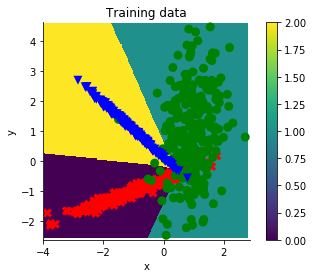

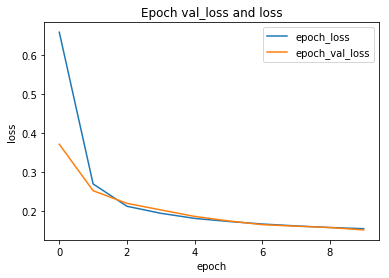

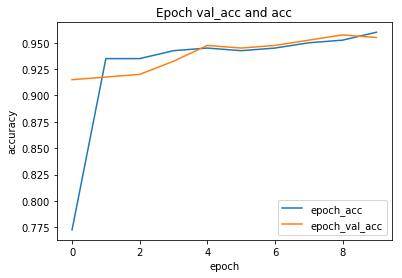

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 18s 44ms/step - loss: 0.7173 - acc: 0.8200 - val_loss: 0.4030 - val_acc: 0.9100
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 0.2949 - acc: 0.9200 - val_loss: 0.2606 - val_acc: 0.9150
Epoch 3/10
400/400 [==============================] - 3s 9ms/step - loss: 0.2261 - acc: 0.9225 - val_loss: 0.2292 - val_acc: 0.9225
Epoch 4/10
400/400 [==============================] - 3s 9ms/step - loss: 0.2060 - acc: 0.9300 - val_loss: 0.2082 - val_acc: 0.9250
Epoch 5/10
400/400 [==============================] - 3s 9ms/step - loss: 0.1941 - acc: 0.9375 - val_loss: 0.1972 - val_acc: 0.9250
Epoch 6/10
400/400 [==============================] - 3s 9ms/step - loss: 0.1857 - acc: 0.9325 - val_loss: 0.1811 - val_acc: 0.9400
Epoch 7/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1792 - acc: 0.9425 - val_loss: 0.1782 - val_acc: 0.9475
Epoch 8/10
400/400 [========

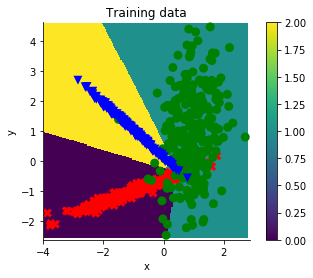

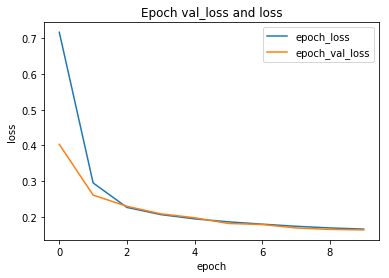

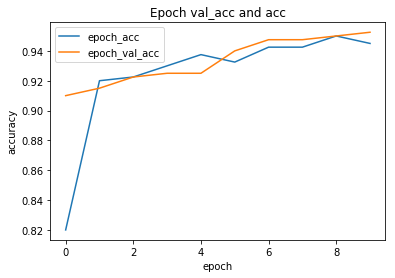

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 16s 40ms/step - loss: 0.6671 - acc: 0.8675 - val_loss: 0.4194 - val_acc: 0.9100
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.2956 - acc: 0.9225 - val_loss: 0.2706 - val_acc: 0.9175
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.2195 - acc: 0.9325 - val_loss: 0.2360 - val_acc: 0.9225
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 0.1979 - acc: 0.9325 - val_loss: 0.2119 - val_acc: 0.9350
Epoch 5/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1882 - acc: 0.9400 - val_loss: 0.1996 - val_acc: 0.9325
Epoch 6/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1791 - acc: 0.9450 - val_loss: 0.1880 - val_acc: 0.9425
Epoch 7/10
400/400 [==============================] - 6s 15ms/step - loss: 0.1757 - acc: 0.9425 - val_loss: 0.1781 - val_acc: 0.9475
Epoch 8/10
400/400 [=======

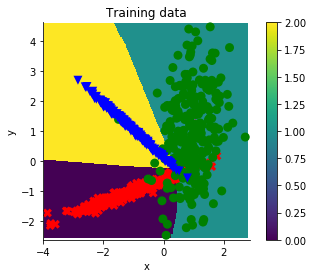

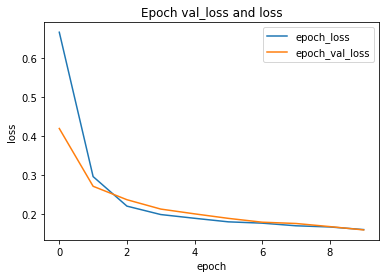

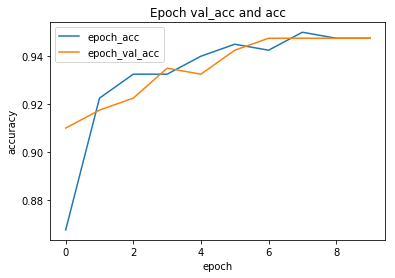


Avg. validation accuracy:0.9495000000000001


(array([[-0.95114463, -0.9197638 ],
        [-1.74490702, -1.41077542],
        [-2.87784334, -1.65772876],
        ...,
        [-2.02021689,  1.96958869],
        [-0.9753455 ,  1.01580138],
        [-0.01489029, -0.71110081]]),
 array([0., 0., 0., 0., 0., 1., 2., 1., 2., 0., 1., 1., 1., 1., 0., 2., 1.,
        2., 1., 2., 2., 0., 1., 2., 1., 1., 0., 2., 1., 0., 0., 2., 1., 2.,
        0., 2., 0., 0., 2., 0., 0., 0., 0., 2., 1., 2., 2., 1., 0., 1., 1.,
        0., 2., 0., 0., 2., 1., 0., 0., 2., 1., 0., 2., 1., 1., 0., 1., 1.,
        2., 0., 1., 1., 1., 0., 2., 2., 1., 2., 0., 1., 1., 1., 2., 1., 2.,
        0., 0., 2., 2., 2., 0., 0., 2., 2., 2., 1., 2., 2., 2., 1., 1., 0.,
        1., 2., 0., 0., 2., 0., 2., 1., 0., 1., 2., 1., 0., 2., 0., 2., 2.,
        0., 2., 2., 1., 1., 2., 0., 2., 2., 1., 2., 1., 1., 2., 0., 0., 1.,
        2., 0., 2., 2., 2., 0., 1., 0., 1., 2., 2., 0., 2., 0., 1., 2., 2.,
        1., 1., 1., 2., 2., 1., 2., 1., 0., 2., 1., 1., 1., 2., 0., 0., 2.,
        1

In [44]:
run_keras_2d("3class", archs(3)[3], 10, split=0.5, trials=5)

Average Validation Accuracy: 95.0%

Architecture: 5

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 20s 49ms/step - loss: 0.2977 - acc: 0.9075 - val_loss: 0.2221 - val_acc: 0.9225
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1669 - acc: 0.9500 - val_loss: 0.1944 - val_acc: 0.9450
Epoch 3/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1449 - acc: 0.9550 - val_loss: 0.1745 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 4s 11ms/step - loss: 0.1358 - acc: 0.9525 - val_loss: 0.1625 - val_acc: 0.9500
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1319 - acc: 0.9600 - val_loss: 0.1436 - val_acc: 0.9575
Epoch 6/10
400/400 [==============================] - 4s 11ms/step - loss: 0.1263 - acc: 0.9625 - val_loss: 0.1259 - val_acc: 0.9600
Epoch 7/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1

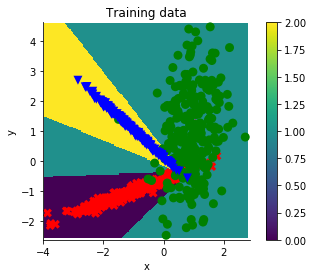

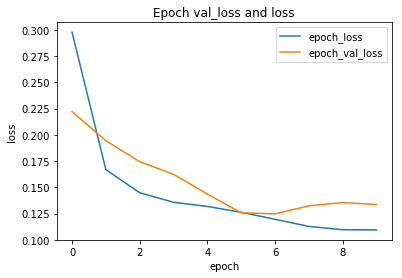

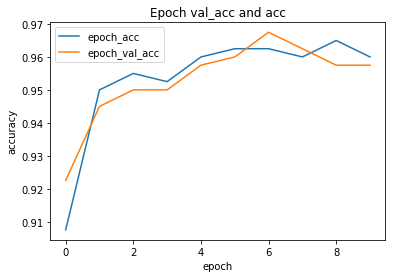

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 21s 53ms/step - loss: 0.2823 - acc: 0.9125 - val_loss: 0.2089 - val_acc: 0.9300
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1647 - acc: 0.9525 - val_loss: 0.1855 - val_acc: 0.9500
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1495 - acc: 0.9575 - val_loss: 0.1638 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 4s 11ms/step - loss: 0.1314 - acc: 0.9625 - val_loss: 0.1464 - val_acc: 0.9575
Epoch 5/10
400/400 [==============================] - 5s 12ms/step - loss: 0.1320 - acc: 0.9600 - val_loss: 0.1428 - val_acc: 0.9525
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1203 - acc: 0.9625 - val_loss: 0.1465 - val_acc: 0.9525
Epoch 7/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1244 - acc: 0.9675 - val_loss: 0.1300 - val_acc: 0.9625
Epoch 8/10
400/400 [====

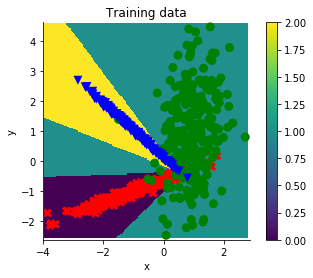

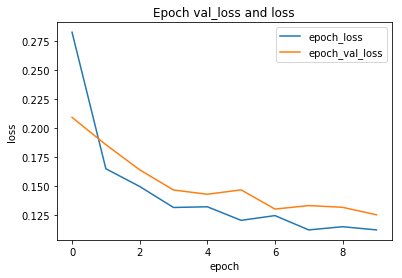

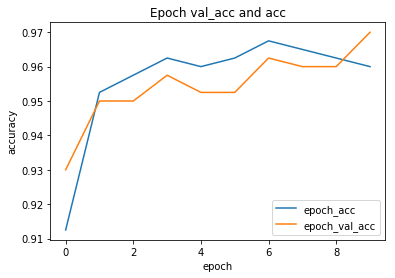

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 18s 46ms/step - loss: 0.3178 - acc: 0.9100 - val_loss: 0.2324 - val_acc: 0.9200
Epoch 2/10
400/400 [==============================] - 3s 9ms/step - loss: 0.1697 - acc: 0.9475 - val_loss: 0.1811 - val_acc: 0.9400
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1518 - acc: 0.9525 - val_loss: 0.1650 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1409 - acc: 0.9525 - val_loss: 0.1461 - val_acc: 0.9500
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1271 - acc: 0.9550 - val_loss: 0.1440 - val_acc: 0.9575
Epoch 6/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1272 - acc: 0.9625 - val_loss: 0.1524 - val_acc: 0.9500
Epoch 7/10
400/400 [==============================] - 4s 11ms/step - loss: 0.1252 - acc: 0.9650 - val_loss: 0.1270 - val_acc: 0.9600
Epoch 8/10
400/400 [====

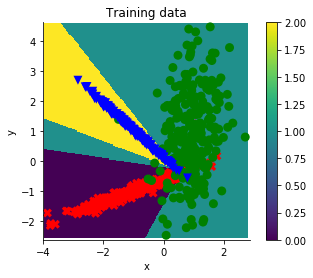

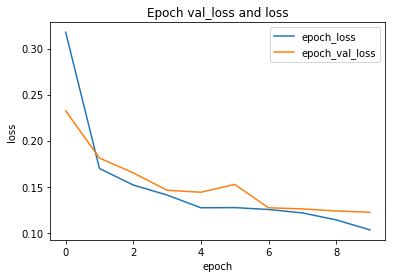

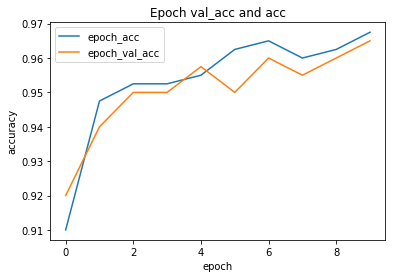

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 19s 47ms/step - loss: 0.3278 - acc: 0.9150 - val_loss: 0.2288 - val_acc: 0.9100
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1679 - acc: 0.9375 - val_loss: 0.1872 - val_acc: 0.9225
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1471 - acc: 0.9575 - val_loss: 0.1704 - val_acc: 0.9475
Epoch 4/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1372 - acc: 0.9575 - val_loss: 0.1556 - val_acc: 0.9450
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1359 - acc: 0.9550 - val_loss: 0.1659 - val_acc: 0.9475
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1307 - acc: 0.9600 - val_loss: 0.1307 - val_acc: 0.9600
Epoch 7/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1247 - acc: 0.9600 - val_loss: 0.1298 - val_acc: 0.9625
Epoch 8/10
400/400 [=====

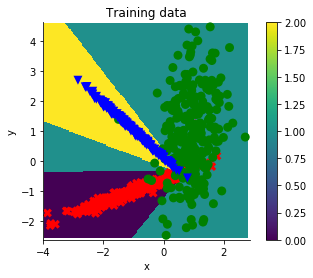

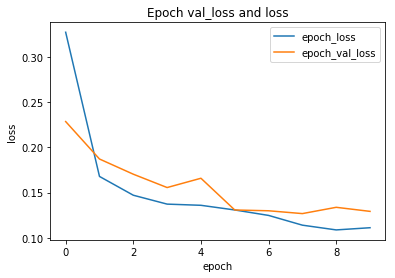

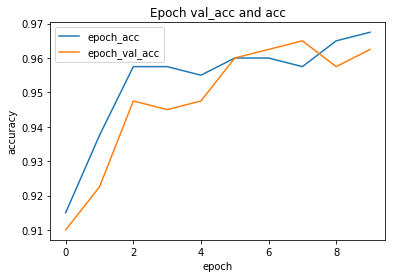

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 17s 44ms/step - loss: 0.3212 - acc: 0.9175 - val_loss: 0.2212 - val_acc: 0.9125
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1682 - acc: 0.9450 - val_loss: 0.1933 - val_acc: 0.9425
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.1490 - acc: 0.9525 - val_loss: 0.1910 - val_acc: 0.9500
Epoch 4/10
400/400 [==============================] - 5s 12ms/step - loss: 0.1410 - acc: 0.9575 - val_loss: 0.1612 - val_acc: 0.9500
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1325 - acc: 0.9575 - val_loss: 0.1539 - val_acc: 0.9500
Epoch 6/10
400/400 [==============================] - 4s 11ms/step - loss: 0.1285 - acc: 0.9575 - val_loss: 0.1531 - val_acc: 0.9525
Epoch 7/10
400/400 [==============================] - 5s 12ms/step - loss: 0.1254 - acc: 0.9600 - val_loss: 0.1424 - val_acc: 0.9625
Epoch 8/10
400/400 [====

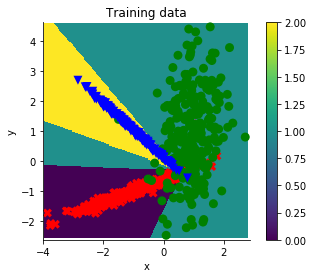

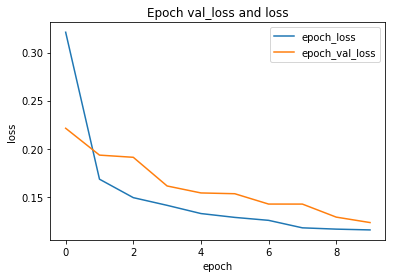

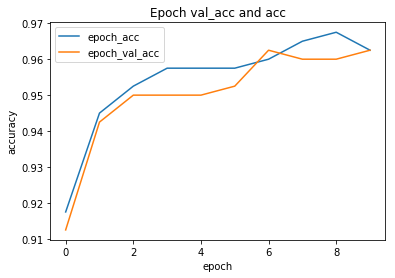


Avg. validation accuracy:0.9635


(array([[ 1.08409889,  0.87702878],
        [-1.6798075 ,  1.58163362],
        [-2.13709378,  2.02089341],
        ...,
        [-1.85954029, -1.37732025],
        [-1.07871796,  1.15294122],
        [ 0.01987391, -0.65713292]]),
 array([1., 2., 2., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1.,
        0., 2., 1., 0., 2., 1., 0., 2., 0., 1., 2., 1., 2., 0., 2., 2., 2.,
        0., 1., 1., 2., 1., 2., 2., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 2., 0., 0., 1., 1., 2., 0., 2., 2., 2., 1., 1., 1., 0., 2., 0.,
        1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 2., 1., 2., 1., 2., 2., 2., 2., 0., 2., 2., 1., 2., 1., 1.,
        0., 2., 1., 0., 1., 1., 2., 1., 1., 2., 1., 2., 1., 0., 1., 1., 0.,
        1., 1., 1., 0., 2., 0., 0., 2., 1., 0., 1., 2., 2., 2., 2., 0., 1.,
        1., 2., 2., 0., 0., 0., 2., 2., 2., 0., 1., 2., 1., 2., 2., 0., 2.,
        2., 0., 0., 1., 2., 0., 1., 0., 2., 2., 2., 1., 0., 0., 0., 1., 2.,
        1

In [45]:
run_keras_2d("3class", archs(3)[4], 10, split=0.5, trials=5)

Average Validation Accuracy: 96.4%

### Part 7

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 19s 49ms/step - loss: 1.5789 - acc: 0.0800 - val_loss: 1.3499 - val_acc: 0.2100
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 1.1561 - acc: 0.4475 - val_loss: 1.0005 - val_acc: 0.5925
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 0.8612 - acc: 0.6250 - val_loss: 0.7664 - val_acc: 0.6650
Epoch 4/10
400/400 [==============================] - 4s 9ms/step - loss: 0.6709 - acc: 0.7525 - val_loss: 0.6209 - val_acc: 0.8250
Epoch 5/10
400/400 [==============================] - 4s 9ms/step - loss: 0.5558 - acc: 0.8975 - val_loss: 0.5339 - val_acc: 0.8975
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4860 - acc: 0.9075 - val_loss: 0.4804 - val_acc: 0.9025
Epoch 7/10
400/400 [==============================] - 5s 11ms/step - loss: 0.4410

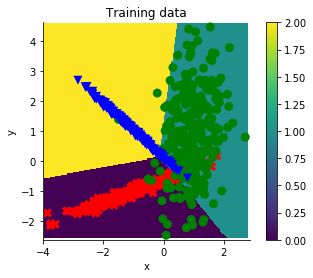

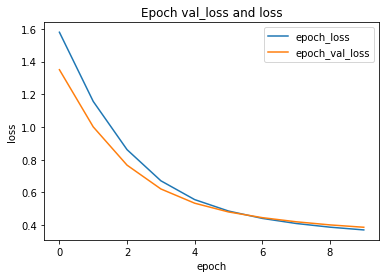

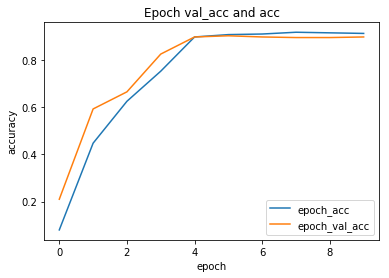


Avg. validation accuracy:0.8975
[2 1 0 1 0 2 1 1]


In [58]:
layers = archs(3)[0]
run_keras_2d("3class", layers, 10, split=0.5, trials=1)

model = Sequential()
model.add(layers[0])

X = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])
Ypred = np.argmax(model.predict(X), axis=1)

print(Ypred)

## Problem 5

In [14]:
def get_MNIST_data(shift=0):
    (X_train, y1), (X_val, y2) = mnist.load_data()
    X_train = X_train / 255
    X_val = X_val / 255
    if shift:
        size = 28+shift
        X_train = shifted(X_train, shift)
        X_val = shifted(X_val, shift)
    return (X_train, y1), (X_val, y2)

In [15]:
def shifted(X, shift):
    n = X.shape[0]
    m = X.shape[1]
    size = m + shift
    X_sh = np.zeros((n, size, size))
    plt.ion()
    for i in range(n):
        sh1 = np.random.randint(shift)
        sh2 = np.random.randint(shift)
        X_sh[i, sh1:sh1+m, sh2:sh2+m] = X[i, :, :]
        # If you want to see the shifts, uncomment
        #plt.figure(1); plt.imshow(X[i])
        #plt.figure(2); plt.imshow(X_sh[i])
        #plt.show()
        #input('Go?')
    return X_sh

In [16]:
def run_keras_fc_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    (X_train, y1), (X_val, y2) = train, test
    # Flatten the images
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m*m))
    X_val = X_val.reshape((X_val.shape[0], m*m))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

In [17]:
def run_keras_cnn_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    # Load the dataset
    (X_train, y1), (X_val, y2) = train, test
    # Add a final dimension indicating the number of channels (only 1 here)
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m, m, 1))
    X_val = X_val.reshape((X_val.shape[0], m, m, 1))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

### Part 2

In [64]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=5)

11493376/11490434 [==============================] - 1s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 30s 504us/step - loss: 11.9571 - acc: 0.2568 - val_loss: 11.6671 - val_acc: 0.2758

Loss on validation set:11.66713601989746 Accuracy on validation set: 0.2758
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 35s 576us/step - loss: 8.0947 - acc: 0.4940 - val_loss: 7.1184 - val_acc: 0.5562

Loss on validation set:7.118371580505371 Accuracy on validation set: 0.5562
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 33s 549us/step - loss: 7.9061 - acc: 0.5056 - val_loss: 6.8572 - val_acc: 0.5729

Loss on validation set:6.857249308013916 Accuracy on validation set: 0.5729
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 33s 556us/step - loss: 5.8982 -

### Part 3

In [65]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=10, activation="softmax", kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None))]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 35s 587us/step - loss: 4.4886 - acc: 0.7100 - val_loss: 4.2175 - val_acc: 0.7340

Loss on validation set:4.217524348068237 Accuracy on validation set: 0.734
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 34s 575us/step - loss: 4.9217 - acc: 0.6829 - val_loss: 4.7393 - val_acc: 0.7007

Loss on validation set:4.739318696594238 Accuracy on validation set: 0.7007
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 36s 599us/step - loss: 2.2284 - acc: 0.8453 - val_loss: 1.6146 - val_acc: 0.8924

Loss on validation set:1.6146324852527163 Accuracy on validation set: 0.8924
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 37s 622us/step - loss: 7.0373 - acc: 0.5564 - val_loss: 6.8223 - val_acc: 0.5741

Loss on validati

### Part 4

In [90]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 34s 562us/step - loss: 0.4718 - acc: 0.8749 - val_loss: 0.3082 - val_acc: 0.9151

Loss on validation set:0.3081873023211956 Accuracy on validation set: 0.9151
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 35s 585us/step - loss: 0.4669 - acc: 0.8794 - val_loss: 0.3091 - val_acc: 0.9176

Loss on validation set:0.30911046923995017 Accuracy on validation set: 0.9176
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 35s 591us/step - loss: 0.4693 - acc: 0.8769 - val_loss: 0.3080 - val_acc: 0.9152

Loss on validation set:0.30804289091229436 Accuracy on validation set: 0.9152
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 36s 595us/step - loss: 0.4680 - acc: 0.8774 - val_loss: 0.3137 - val_acc: 0.9130

Loss on val

### Part 6

In [91]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 5, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 36s 602us/step - loss: 0.4729 - acc: 0.8755 - val_loss: 0.3062 - val_acc: 0.9159
Epoch 2/5
60000/60000 [==============================] - 20s 337us/step - loss: 0.3044 - acc: 0.9148 - val_loss: 0.2825 - val_acc: 0.9209
Epoch 3/5
60000/60000 [==============================] - 21s 343us/step - loss: 0.2831 - acc: 0.9206 - val_loss: 0.2729 - val_acc: 0.9234
Epoch 4/5
60000/60000 [==============================] - 19s 314us/step - loss: 0.2729 - acc: 0.9238 - val_loss: 0.2728 - val_acc: 0.9243
Epoch 5/5
60000/60000 [==============================] - 19s 309us/step - loss: 0.2661 - acc: 0.9266 - val_loss: 0.2691 - val_acc: 0.9256

Loss on validation set:0.2690907533228397 Accuracy on validation set: 0.9256

Avg. validation accuracy:0.9256


Average Validation Accuracy: 92.6%

In [92]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 10, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 613us/step - loss: 0.4685 - acc: 0.8799 - val_loss: 0.3071 - val_acc: 0.9138
Epoch 2/10
60000/60000 [==============================] - 19s 312us/step - loss: 0.3031 - acc: 0.9159 - val_loss: 0.2820 - val_acc: 0.9213
Epoch 3/10
60000/60000 [==============================] - 19s 313us/step - loss: 0.2827 - acc: 0.9211 - val_loss: 0.2730 - val_acc: 0.9237
Epoch 4/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.2729 - acc: 0.9240 - val_loss: 0.2730 - val_acc: 0.9230
Epoch 5/10
60000/60000 [==============================] - 19s 318us/step - loss: 0.2664 - acc: 0.9255 - val_loss: 0.2691 - val_acc: 0.9259
Epoch 6/10
60000/60000 [==============================] - 19s 319us/step - loss: 0.2616 - acc: 0.9278 - val_loss: 0.2667 - val_acc: 0.9274
Epoch 7/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.2579 - acc: 0.9288 - val_loss: 0.

Average Validation Accuracy: 92.9%

In [93]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 15, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 37s 620us/step - loss: 0.4717 - acc: 0.8763 - val_loss: 0.3100 - val_acc: 0.9153
Epoch 2/15
60000/60000 [==============================] - 23s 378us/step - loss: 0.3039 - acc: 0.9149 - val_loss: 0.2837 - val_acc: 0.9210
Epoch 3/15
60000/60000 [==============================] - 19s 321us/step - loss: 0.2834 - acc: 0.9207 - val_loss: 0.2738 - val_acc: 0.9237
Epoch 4/15
60000/60000 [==============================] - 18s 303us/step - loss: 0.2732 - acc: 0.9231 - val_loss: 0.2696 - val_acc: 0.9256
Epoch 5/15
60000/60000 [==============================] - 18s 299us/step - loss: 0.2664 - acc: 0.9259 - val_loss: 0.2644 - val_acc: 0.9273
Epoch 6/15
60000/60000 [==============================] - 18s 296us/step - loss: 0.2616 - acc: 0.9274 - val_loss: 0.2679 - val_acc: 0.9239
Epoch 7/15
60000/60000 [==============================] - 18s 294us/step - loss: 0.2577 - acc: 0.9282 - val_loss: 0.

Average Validation Accuracy: 92.9%

### Part 8

In [96]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=128, activation="relu"),
          Dense(input_dim=128, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 43s 711us/step - loss: 0.2565 - acc: 0.9266 - val_loss: 0.1347 - val_acc: 0.9615

Loss on validation set:0.1347456404145807 Accuracy on validation set: 0.9615

Avg. validation accuracy:0.9615


In [97]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=256, activation="relu"),
          Dense(input_dim=256, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 40s 669us/step - loss: 0.2277 - acc: 0.9344 - val_loss: 0.1164 - val_acc: 0.9653

Loss on validation set:0.11637950807325542 Accuracy on validation set: 0.9653

Avg. validation accuracy:0.9653


In [98]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=512, activation="relu"),
          Dense(input_dim=512, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 47s 777us/step - loss: 0.1999 - acc: 0.9419 - val_loss: 0.0945 - val_acc: 0.9713

Loss on validation set:0.09450303235314786 Accuracy on validation set: 0.9713

Avg. validation accuracy:0.9713


In [99]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=1024, activation="relu"),
          Dense(input_dim=1024, units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1844 - acc: 0.9451 - val_loss: 0.0955 - val_acc: 0.9701

Loss on validation set:0.09546600921377539 Accuracy on validation set: 0.9701

Avg. validation accuracy:0.9701


### Part 9

In [100]:
train, test = get_MNIST_data()
layers = [Dense(input_dim=784, units=512, activation="relu"),
          Dense(units=256, activation="relu"),
          Dense(units=10, activation="softmax")]
run_keras_fc_mnist(train, test, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1898 - acc: 0.9431 - val_loss: 0.0981 - val_acc: 0.9683

Loss on validation set:0.09813930251915008 Accuracy on validation set: 0.9683

Avg. validation accuracy:0.9683


### Part 10

In [102]:
train, test = get_MNIST_data()
layers = [Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),
          MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
          MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
          Flatten(),
          Dense(units=128, activation='relu'),
          Dropout(0.5),
          Dense(units=10, activation='softmax')]
run_keras_cnn_mnist(train, test, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 428s 7ms/step - loss: 0.1803 - acc: 0.9467 - val_loss: 0.0386 - val_acc: 0.9869

Loss on validation set:0.03860895690090256 Accuracy on validation set: 0.9869

Avg. validation accuracy:0.9869


### Part 11

In [18]:
train_20, test_20 = get_MNIST_data(shift=20)

In [19]:
layers = [Dense(input_dim=2304, units=512, activation="relu"),
          Dense(units=256, activation="relu"),
          Dense(units=10, activation="softmax")]
run_keras_fc_mnist(train_20, test_20, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 47s 787us/step - loss: 0.7481 - acc: 0.7548 - val_loss: 0.3913 - val_acc: 0.8758

Loss on validation set:0.39126335756182673 Accuracy on validation set: 0.8758

Avg. validation accuracy:0.8758


In [20]:
layers = [Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(48, 48, 1)),
          MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
          MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
          Flatten(),
          Dense(units=128, activation='relu'),
          Dropout(0.5),
          Dense(units=10, activation='softmax')]
run_keras_cnn_mnist(train_20, test_20, layers, 1, split=0.1, trials=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2037s 34ms/step - loss: 0.7619 - acc: 0.7449 - val_loss: 0.1892 - val_acc: 0.9443

Loss on validation set:0.18923047743141652 Accuracy on validation set: 0.9443

Avg. validation accuracy:0.9443
